## Задание

Создайте автокодировщик, удаляющий черные квадраты в случайных областях изображений.

Алгоритм действий:
1. Возьмите базу картинок Mnist.
2. На картинках в случайных местах сделайте чёрные квадраты размера 8 на 8.
3. Создайте и обучите автокодировщик восстанавливать оригинальные изображения из "зашумленных" квадратом изображений.
4. Добейтесь MSE < 0.0070 на тестовой выборке

## Импорт библиотек

In [1]:
# Отображение
import matplotlib.pyplot as plt

# Для работы с тензорами
import numpy as np

# Класс создания модели
from tensorflow.keras.models import Model

# Для загрузки данных
from tensorflow.keras.datasets import mnist

# Необходимые слои
from tensorflow.keras.layers import Input, Conv2DTranspose, MaxPooling2D, Conv2D, BatchNormalization

# Оптимизатор
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import LambdaCallback

E0000 00:00:1748130289.948704   20777 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748130289.956957   20777 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Данные

In [2]:
# Загрузка данных
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
# Нормировка данных
X_train = X_train.astype('float32')/255.
X_test = X_test.astype('float32')/255.

In [4]:
# Изменение формы под удобную для Keras
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

In [5]:
print(f"Размерность тренировочной выборки: {X_train.shape}")
print(f"Размерность тестовой выборки: {X_test.shape}")

Размерность тренировочной выборки: (60000, 28, 28, 1)
Размерность тестовой выборки: (10000, 28, 28, 1)


In [ ]:
# Ваше решение
def add_noise_squares(images, square_size=8):
    noisy_images = np.copy(images)
    img_height, img_width = images.shape[1], images.shape[2]

    center_start_coord = (img_width - 20) // 2
    center_end_coord = center_start_coord + 20 - 1

    for i in range(noisy_images.shape[0]):

        valid_start_min = center_start_coord
        valid_start_max = center_end_coord - square_size + 1

        if valid_start_min > valid_start_max:
            valid_start_max = valid_start_min 

        x_start = np.random.randint(valid_start_min, valid_start_max + 1)
        y_start = np.random.randint(valid_start_min, valid_start_max + 1)

        noisy_images[
            i, y_start : y_start + square_size, x_start : x_start + square_size, :
        ] = 0.0

    return noisy_images

In [15]:
X_train_noisy = add_noise_squares(X_train, square_size=8)
X_test_noisy = add_noise_squares(X_test, square_size=8)

In [16]:
print(f"Размерность зашумленной тренировочной выборки: {X_train_noisy.shape}")
print(f"Размерность зашумленной тестовой выборки: {X_test_noisy.shape}")

Размерность зашумленной тренировочной выборки: (60000, 28, 28, 1)
Размерность зашумленной тестовой выборки: (10000, 28, 28, 1)


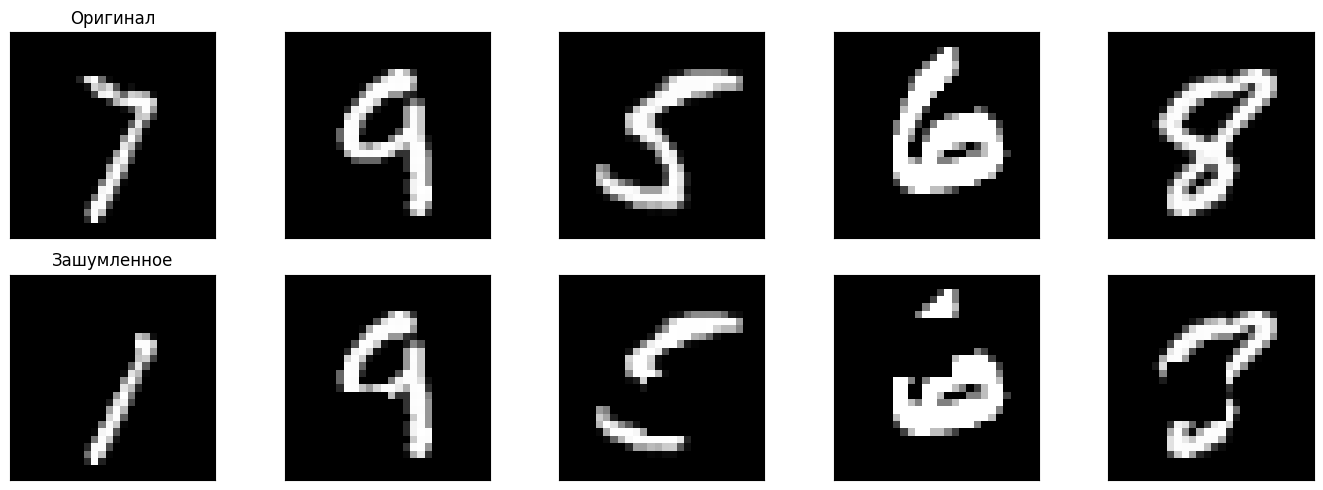

In [17]:
plt.figure(figsize=(14, 5))
for i in range(5):
    idx = np.random.randint(0, X_train.shape[0])
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx].squeeze(), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Оригинал")

    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(X_train_noisy[idx].squeeze(), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Зашумленное")
plt.tight_layout()
plt.show()


In [ ]:
def create_denoising_ae_conv(in_shape):
    img_input = Input(in_shape)

    x = Conv2D(32, (3, 3), padding="same", activation="relu")(img_input)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding="same")(x)

    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding="same")(x)

    encoded = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    encoded = BatchNormalization()(encoded)

    input_encoded = Input(shape=encoded.shape[1:])

    x = Conv2DTranspose(64, (2, 2), (2, 2), padding="same", activation="relu")(
        input_encoded
    )
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(32, (2, 2), (2, 2), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    decoded = Conv2D(in_shape[-1], (3, 3), activation="sigmoid", padding="same")(x)

    encoder = Model(img_input, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(img_input, decoder(encoder(img_input)), name="autoencoder")

    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

    return autoencoder, encoder, decoder


In [ ]:
denoising_ae, encoder, decoder = create_denoising_ae_conv(X_train.shape[1:])


print(f"Входная форма автокодировщика: {denoising_ae.input_shape}")
print(f"Выходная форма автокодировщика: {denoising_ae.output_shape}")


Входная форма автокодировщика: (None, 28, 28, 1)
Выходная форма автокодировщика: (None, 28, 28, 1)


In [ ]:
def denoising_callback(epoch, logs):
    print("________________________")
    print(
        f"*** ЭПОХА: {epoch + 1}, Обучающая MSE: {logs['loss']:.5f}, Тестовая MSE: {logs['val_loss']:.5f} ***"
    )
    print("________________________")


    idx = np.random.randint(0, X_test.shape[0])
    original_img = X_test[idx : idx + 1]  
    noisy_img = X_test_noisy[idx : idx + 1] 


    reconstructed_img = denoising_ae.predict(
        noisy_img, verbose=0
    ) 

    plt.figure(figsize=(10, 4))

    ax = plt.subplot(1, 3, 1)
    plt.imshow(original_img.squeeze(), cmap="gray")
    ax.set_title("Оригинал")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    ax = plt.subplot(1, 3, 2)
    plt.imshow(noisy_img.squeeze(), cmap="gray")
    ax.set_title("Зашумленное")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    ax = plt.subplot(1, 3, 3)
    plt.imshow(reconstructed_img.squeeze(), cmap="gray")
    ax.set_title("Восстановленное")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.show()



________________________
*** ЭПОХА: 1, Обучающая MSE: 0.02875, Тестовая MSE: 0.12144 ***
________________________


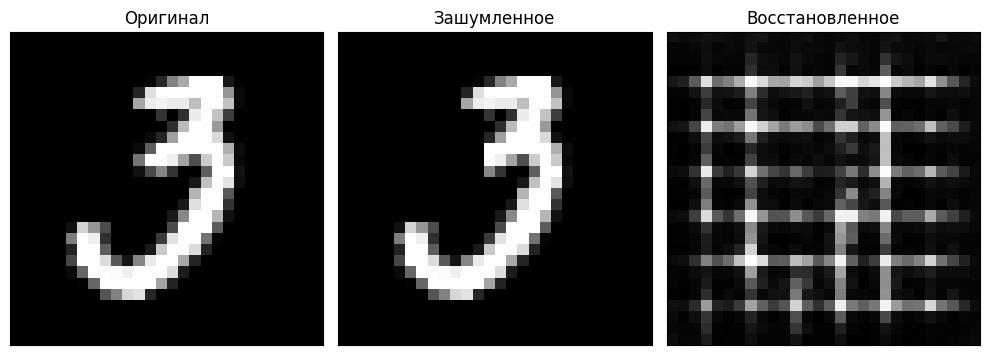

________________________
*** ЭПОХА: 2, Обучающая MSE: 0.00786, Тестовая MSE: 0.03287 ***
________________________


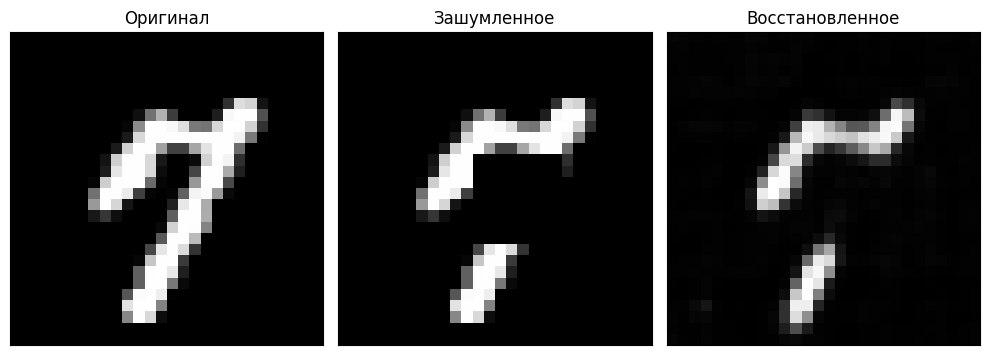

________________________
*** ЭПОХА: 3, Обучающая MSE: 0.00644, Тестовая MSE: 0.01009 ***
________________________


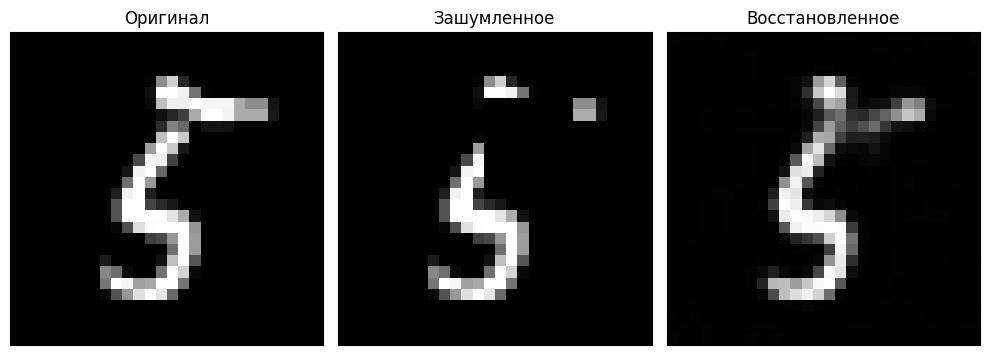

________________________
*** ЭПОХА: 4, Обучающая MSE: 0.00585, Тестовая MSE: 0.00577 ***
________________________


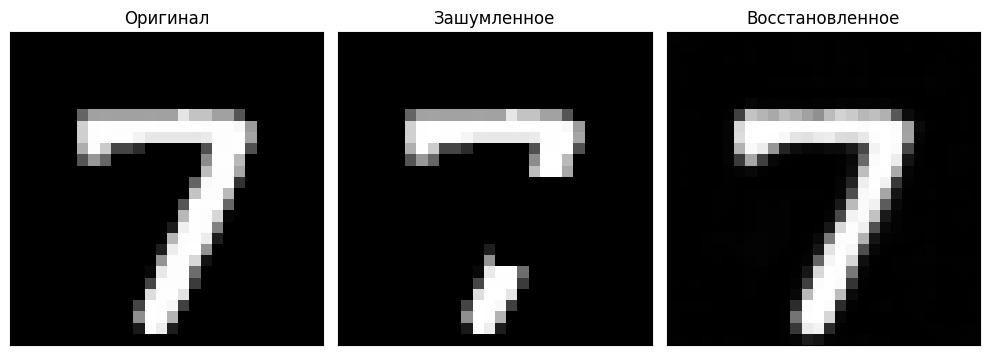

________________________
*** ЭПОХА: 5, Обучающая MSE: 0.00540, Тестовая MSE: 0.00593 ***
________________________


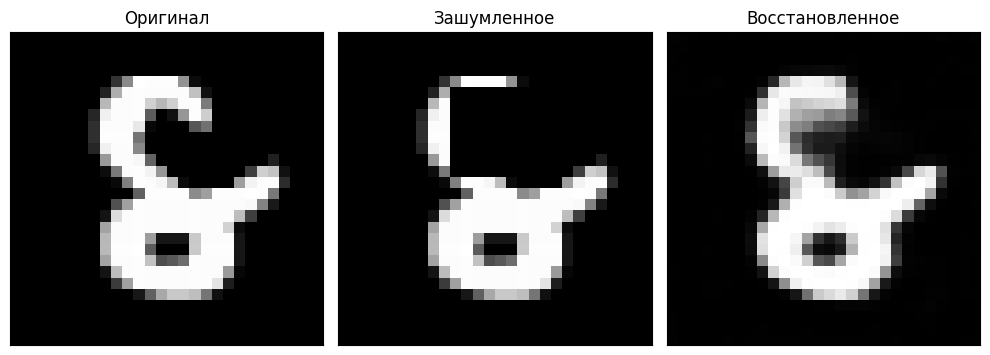

________________________
*** ЭПОХА: 6, Обучающая MSE: 0.00507, Тестовая MSE: 0.00673 ***
________________________


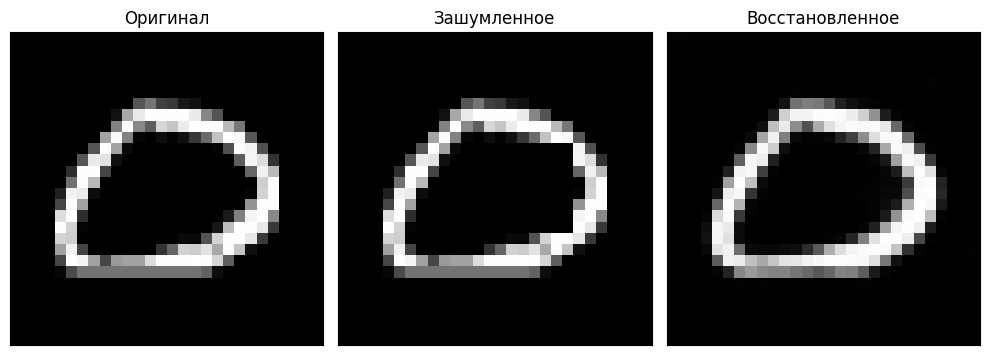

________________________
*** ЭПОХА: 7, Обучающая MSE: 0.00489, Тестовая MSE: 0.00551 ***
________________________


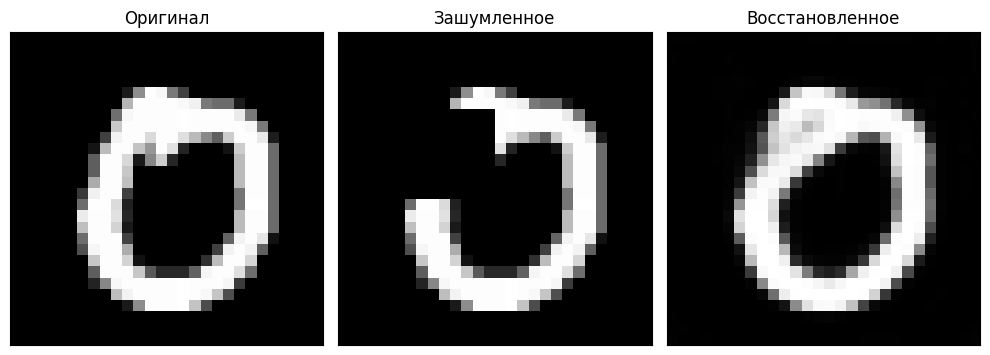

________________________
*** ЭПОХА: 8, Обучающая MSE: 0.00468, Тестовая MSE: 0.00588 ***
________________________


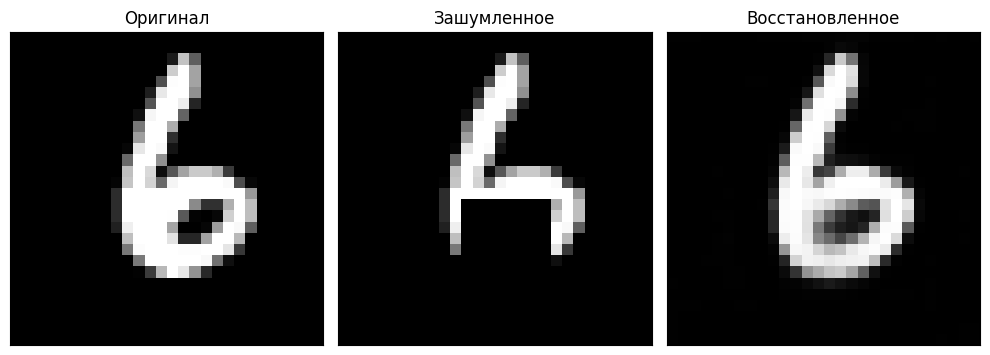

________________________
*** ЭПОХА: 9, Обучающая MSE: 0.00453, Тестовая MSE: 0.00499 ***
________________________


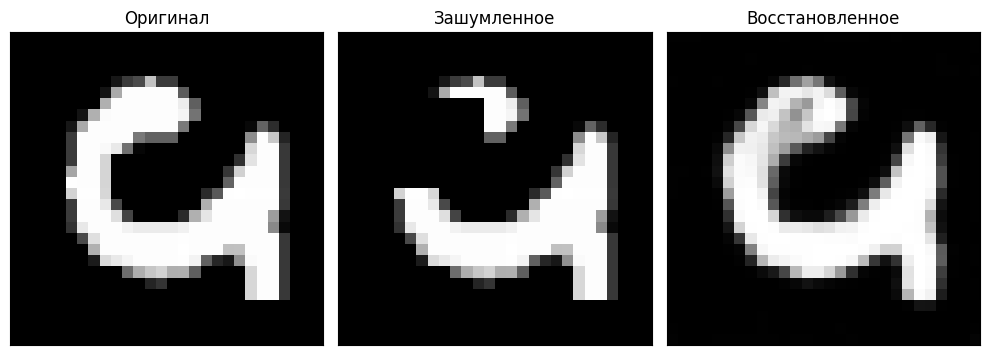

________________________
*** ЭПОХА: 10, Обучающая MSE: 0.00436, Тестовая MSE: 0.00498 ***
________________________


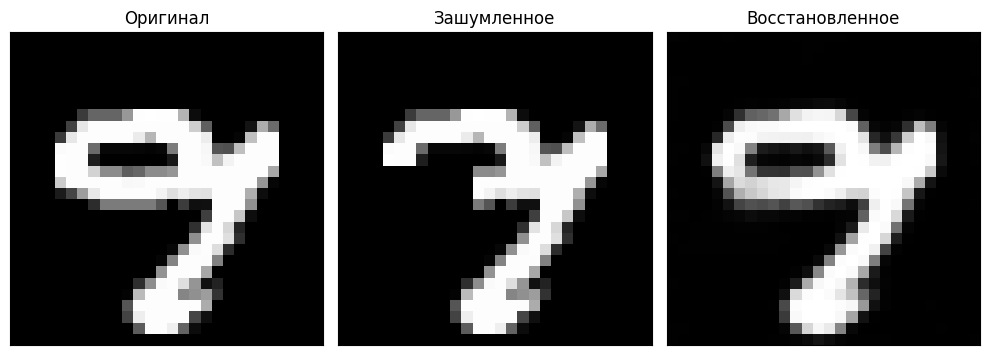

________________________
*** ЭПОХА: 11, Обучающая MSE: 0.00425, Тестовая MSE: 0.00551 ***
________________________


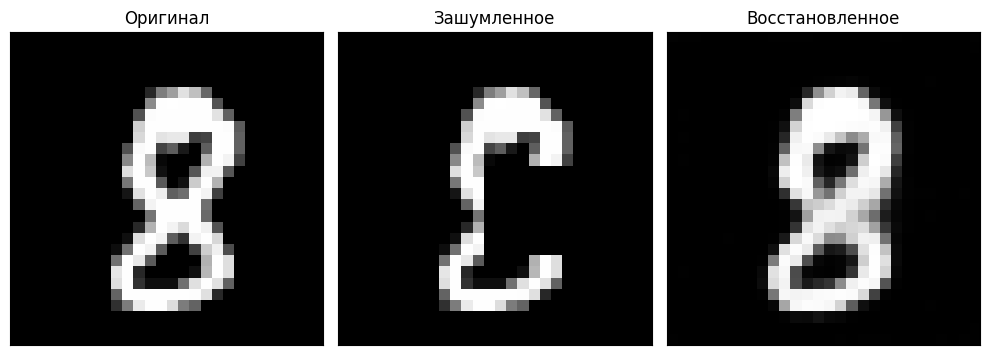

________________________
*** ЭПОХА: 12, Обучающая MSE: 0.00413, Тестовая MSE: 0.00495 ***
________________________


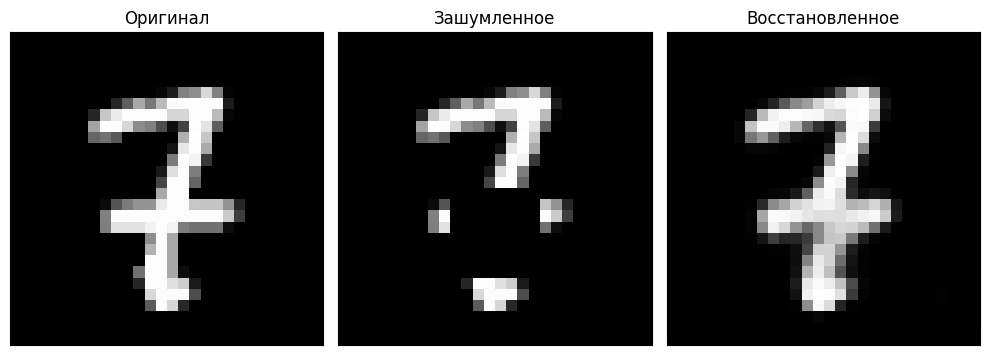

________________________
*** ЭПОХА: 13, Обучающая MSE: 0.00404, Тестовая MSE: 0.00457 ***
________________________


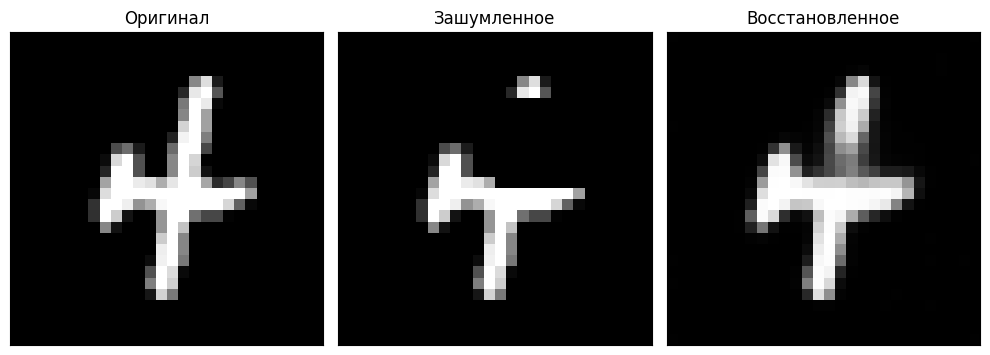

________________________
*** ЭПОХА: 14, Обучающая MSE: 0.00394, Тестовая MSE: 0.00464 ***
________________________


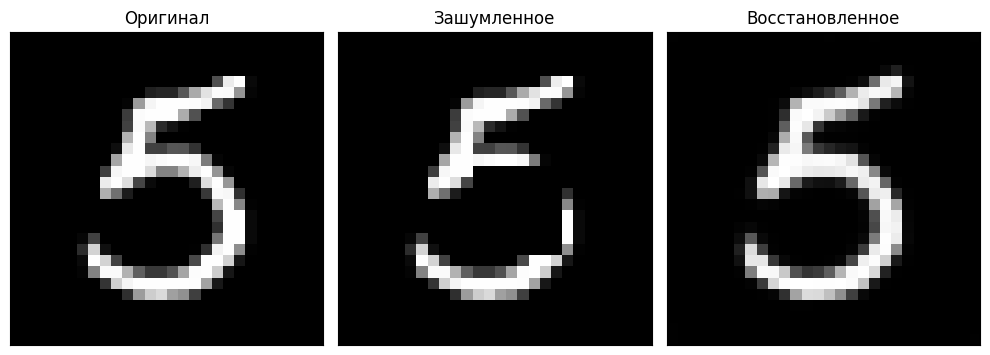

________________________
*** ЭПОХА: 15, Обучающая MSE: 0.00388, Тестовая MSE: 0.00489 ***
________________________


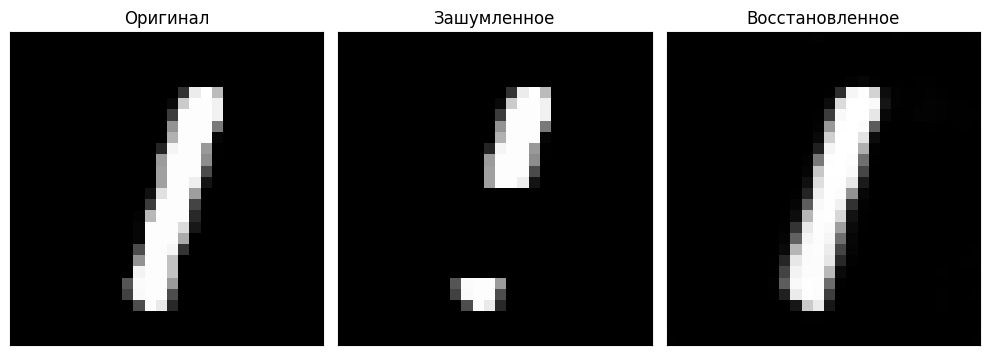

________________________
*** ЭПОХА: 16, Обучающая MSE: 0.00378, Тестовая MSE: 0.00473 ***
________________________


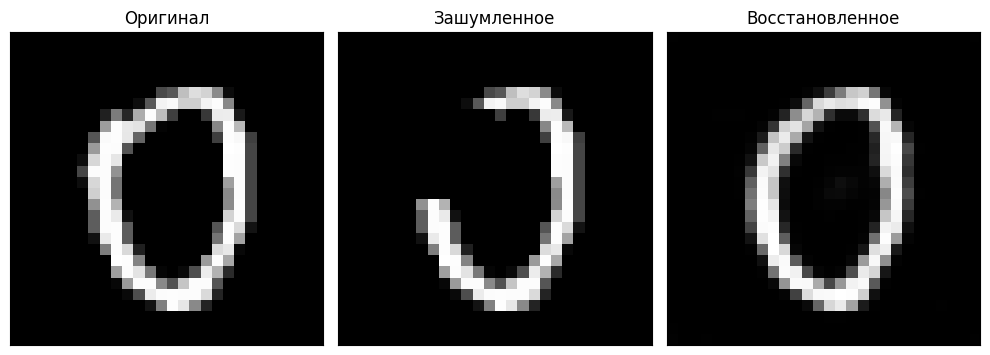

________________________
*** ЭПОХА: 17, Обучающая MSE: 0.00375, Тестовая MSE: 0.00472 ***
________________________


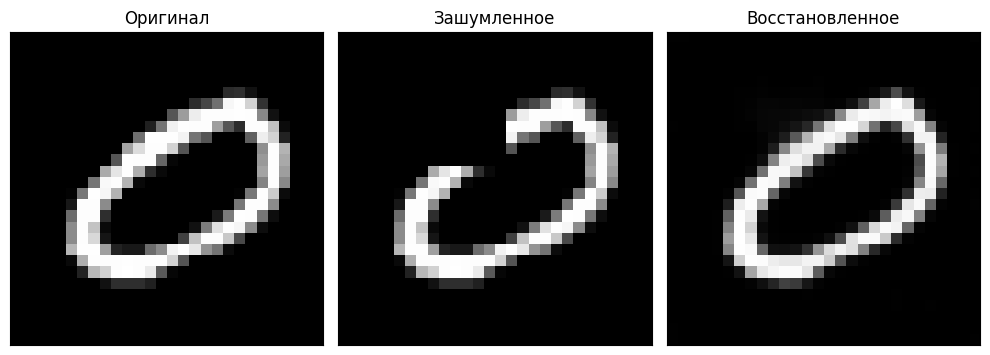

________________________
*** ЭПОХА: 18, Обучающая MSE: 0.00367, Тестовая MSE: 0.00441 ***
________________________


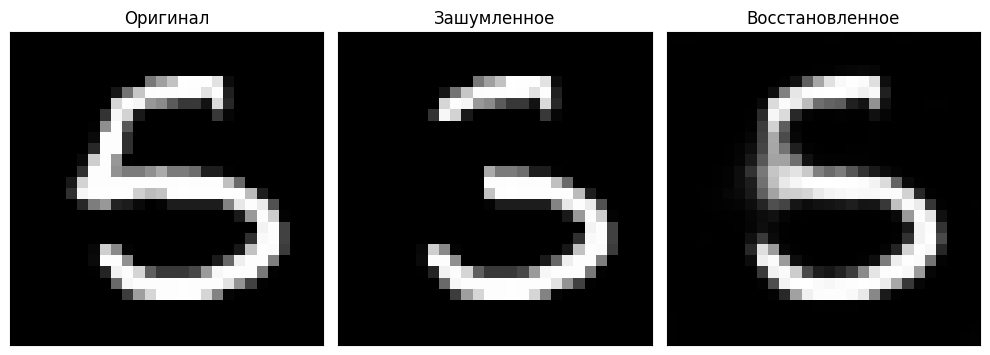

________________________
*** ЭПОХА: 19, Обучающая MSE: 0.00367, Тестовая MSE: 0.00443 ***
________________________


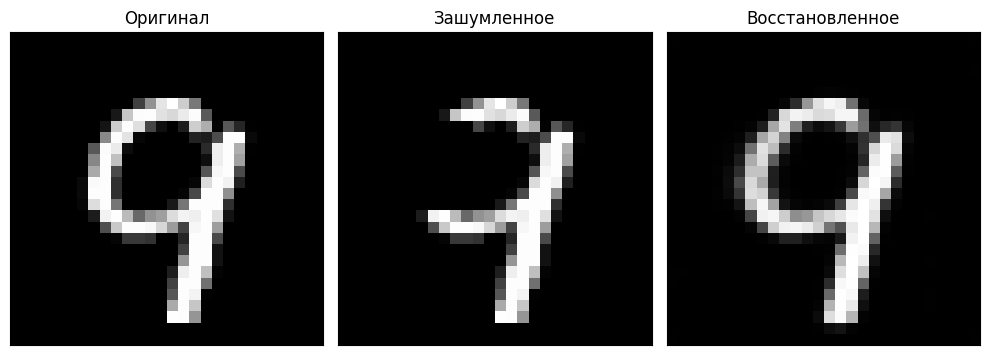

________________________
*** ЭПОХА: 20, Обучающая MSE: 0.00354, Тестовая MSE: 0.00473 ***
________________________


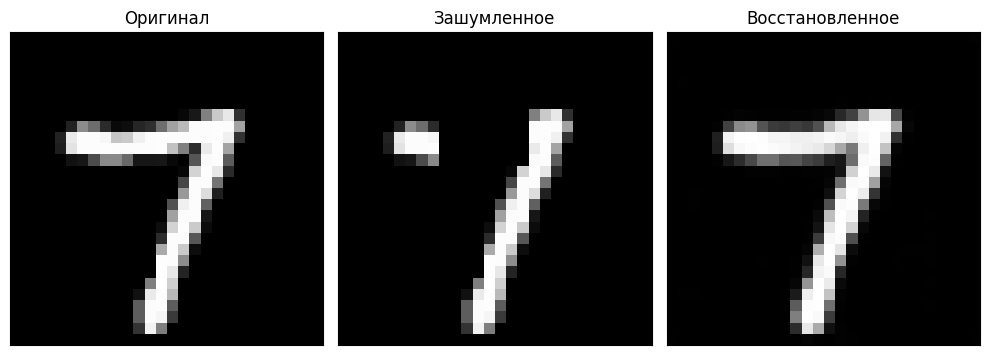

________________________
*** ЭПОХА: 21, Обучающая MSE: 0.00347, Тестовая MSE: 0.00461 ***
________________________


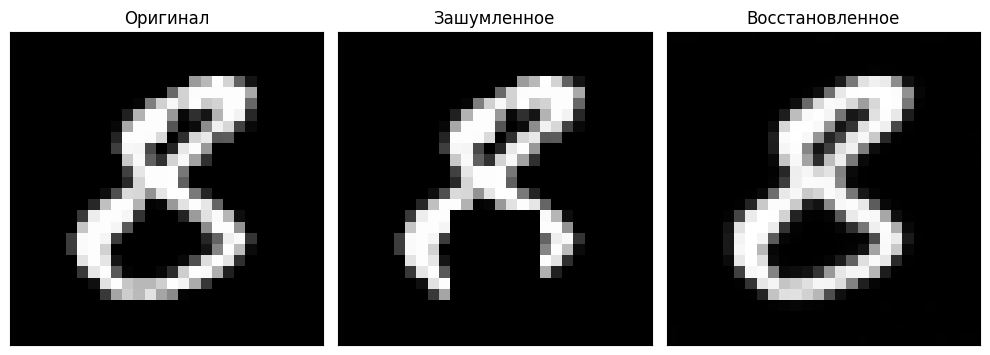

________________________
*** ЭПОХА: 22, Обучающая MSE: 0.00344, Тестовая MSE: 0.00457 ***
________________________


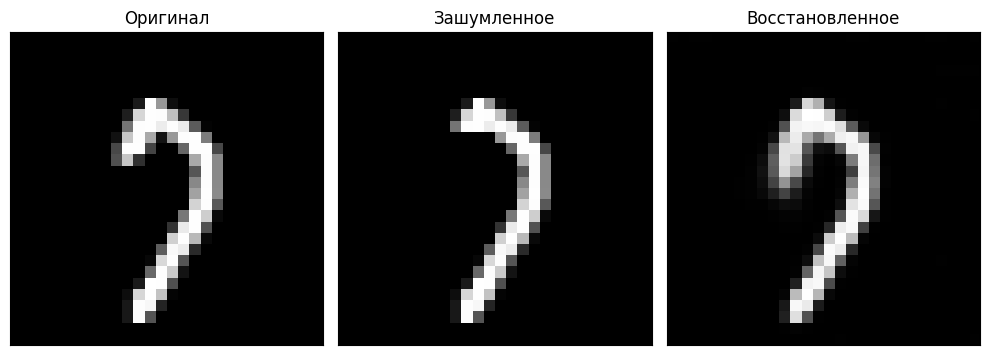

________________________
*** ЭПОХА: 23, Обучающая MSE: 0.00339, Тестовая MSE: 0.00439 ***
________________________


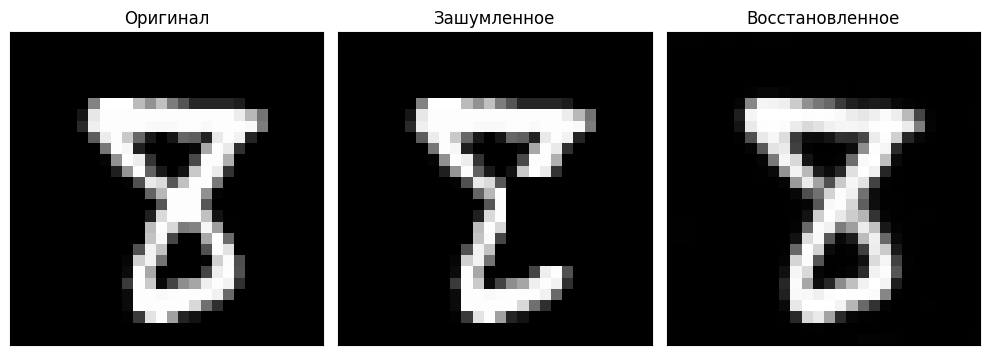

________________________
*** ЭПОХА: 24, Обучающая MSE: 0.00332, Тестовая MSE: 0.00475 ***
________________________


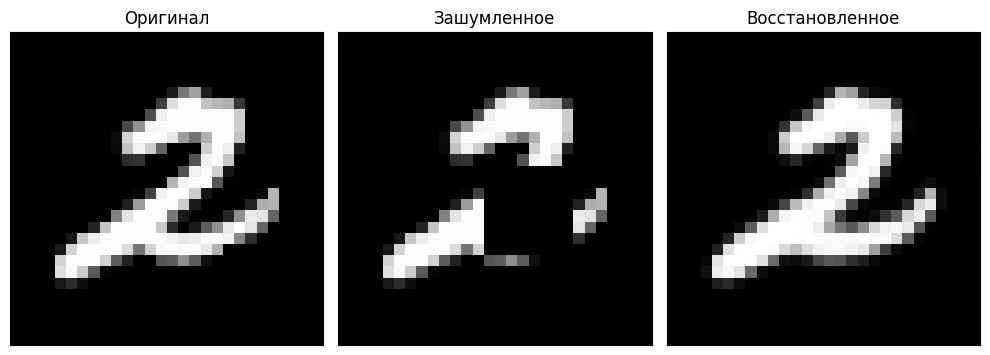

________________________
*** ЭПОХА: 25, Обучающая MSE: 0.00327, Тестовая MSE: 0.00521 ***
________________________


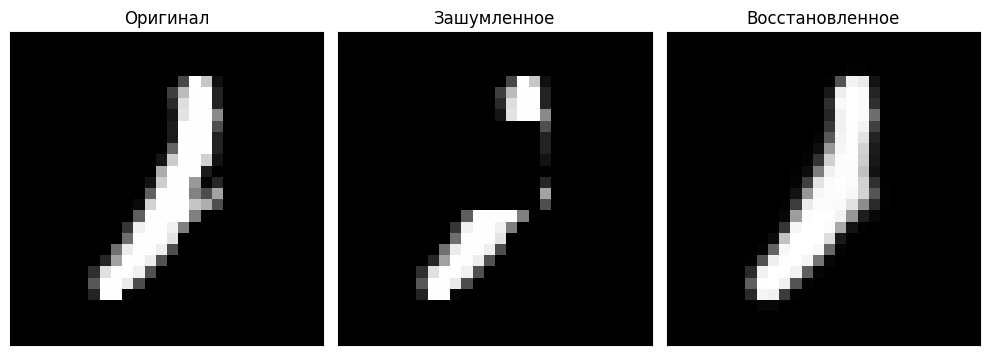

________________________
*** ЭПОХА: 26, Обучающая MSE: 0.00323, Тестовая MSE: 0.00444 ***
________________________


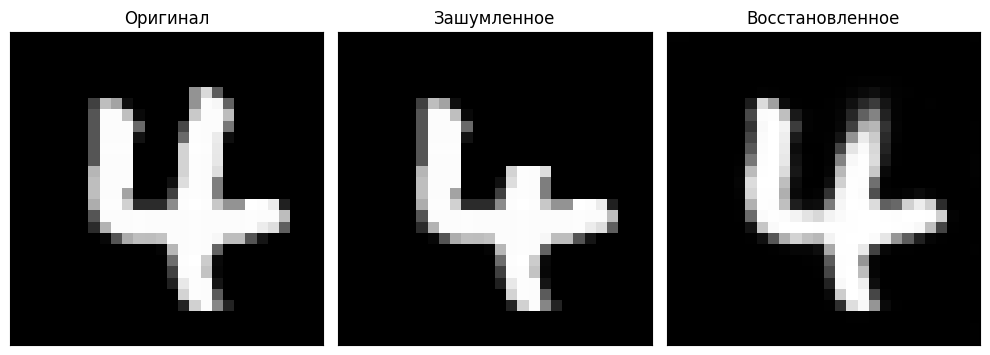

________________________
*** ЭПОХА: 27, Обучающая MSE: 0.00320, Тестовая MSE: 0.00445 ***
________________________


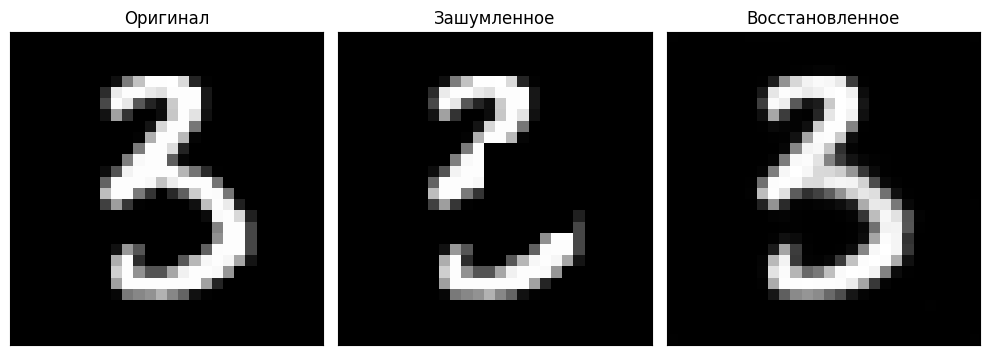

________________________
*** ЭПОХА: 28, Обучающая MSE: 0.00314, Тестовая MSE: 0.00468 ***
________________________


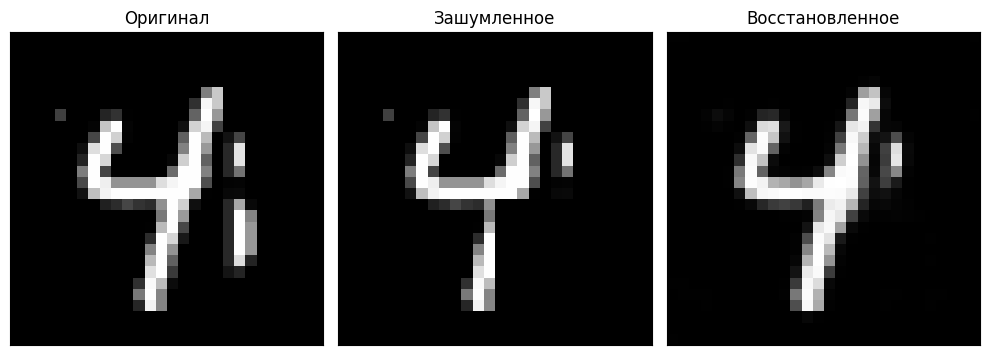

________________________
*** ЭПОХА: 29, Обучающая MSE: 0.00311, Тестовая MSE: 0.00428 ***
________________________


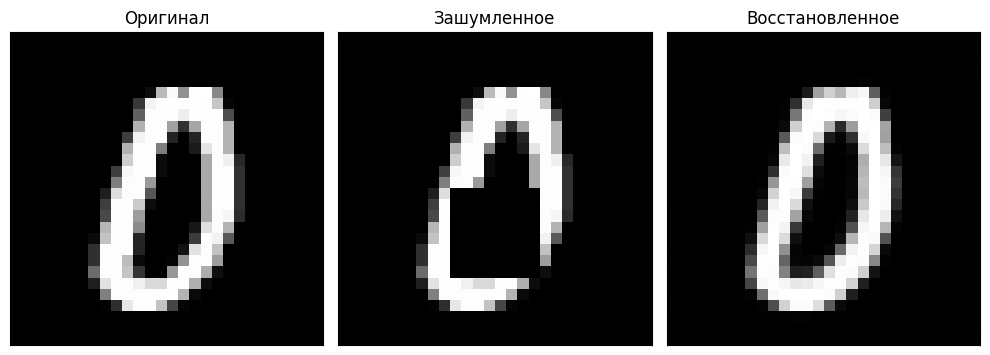

________________________
*** ЭПОХА: 30, Обучающая MSE: 0.00308, Тестовая MSE: 0.00426 ***
________________________


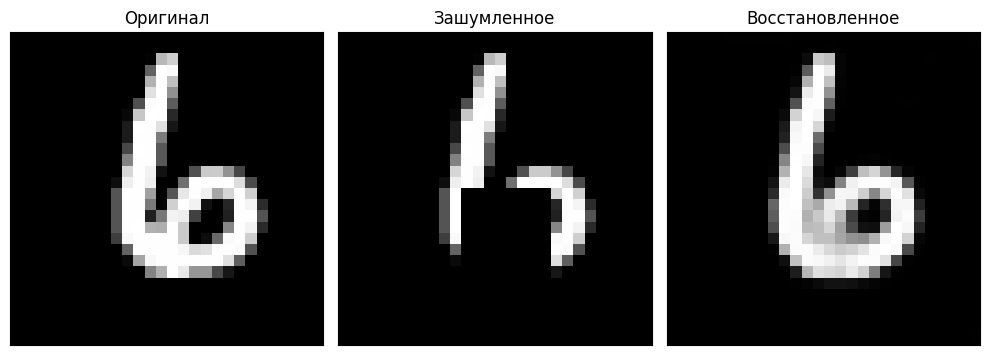

________________________
*** ЭПОХА: 31, Обучающая MSE: 0.00305, Тестовая MSE: 0.00439 ***
________________________


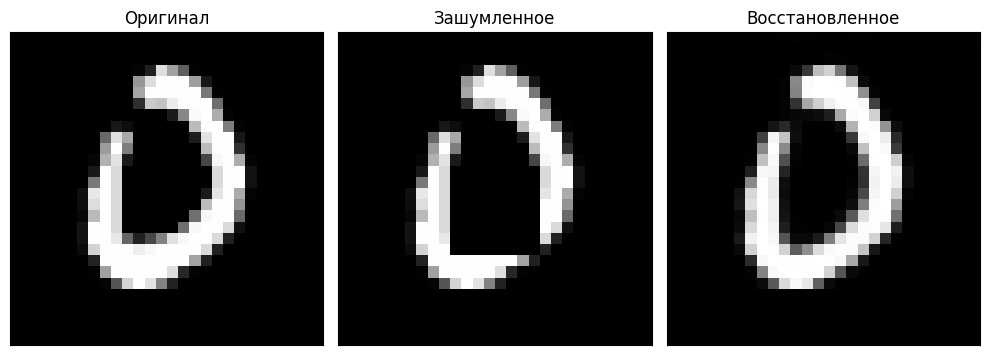

________________________
*** ЭПОХА: 32, Обучающая MSE: 0.00298, Тестовая MSE: 0.00487 ***
________________________


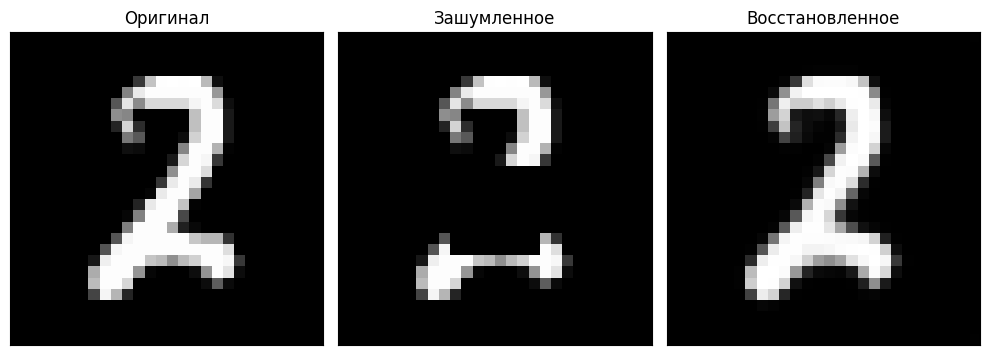

________________________
*** ЭПОХА: 33, Обучающая MSE: 0.00296, Тестовая MSE: 0.00436 ***
________________________


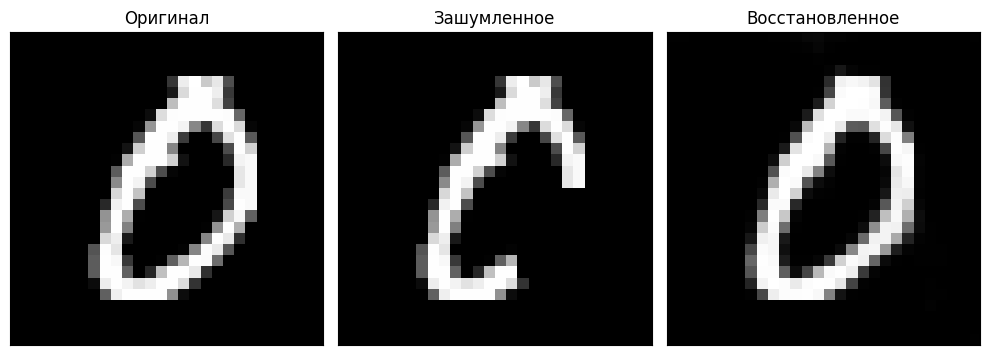

________________________
*** ЭПОХА: 34, Обучающая MSE: 0.00292, Тестовая MSE: 0.00442 ***
________________________


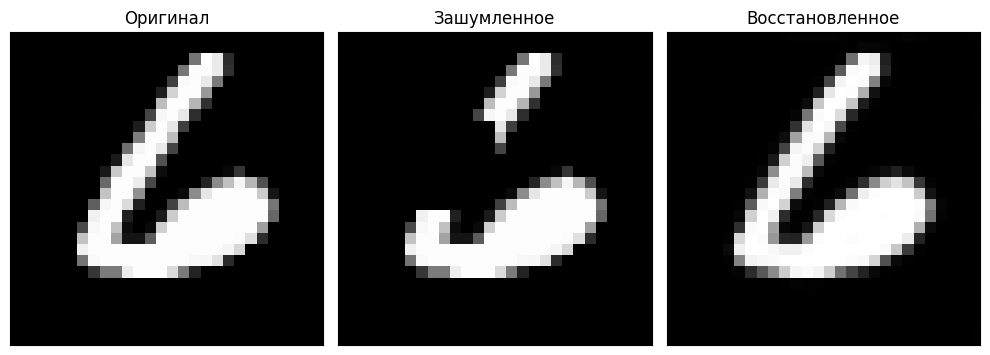

________________________
*** ЭПОХА: 35, Обучающая MSE: 0.00288, Тестовая MSE: 0.00438 ***
________________________


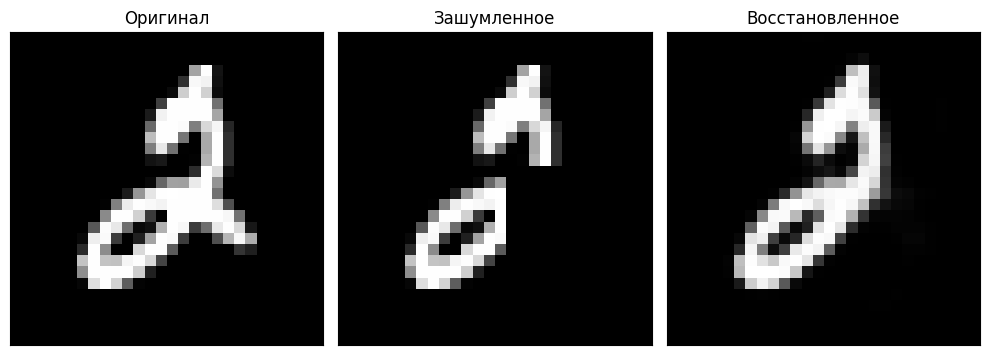

________________________
*** ЭПОХА: 36, Обучающая MSE: 0.00285, Тестовая MSE: 0.00443 ***
________________________


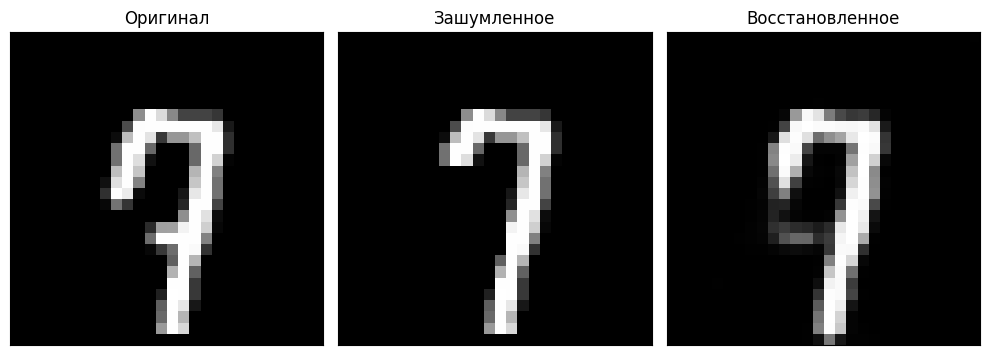

________________________
*** ЭПОХА: 37, Обучающая MSE: 0.00284, Тестовая MSE: 0.00438 ***
________________________


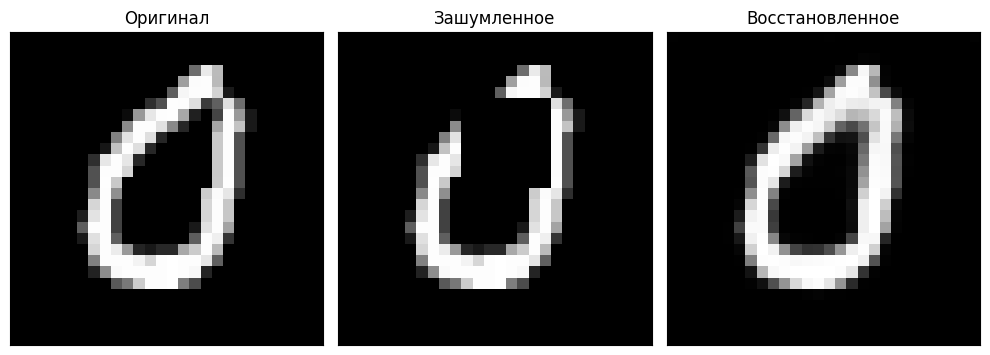

________________________
*** ЭПОХА: 38, Обучающая MSE: 0.00282, Тестовая MSE: 0.00444 ***
________________________


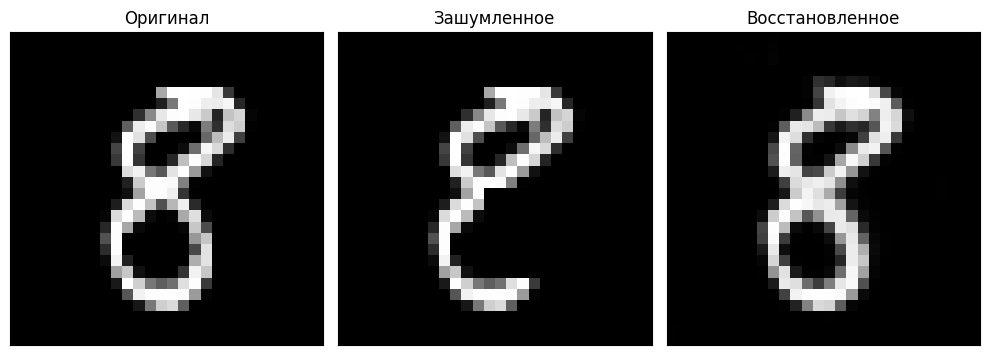

________________________
*** ЭПОХА: 39, Обучающая MSE: 0.00279, Тестовая MSE: 0.00425 ***
________________________


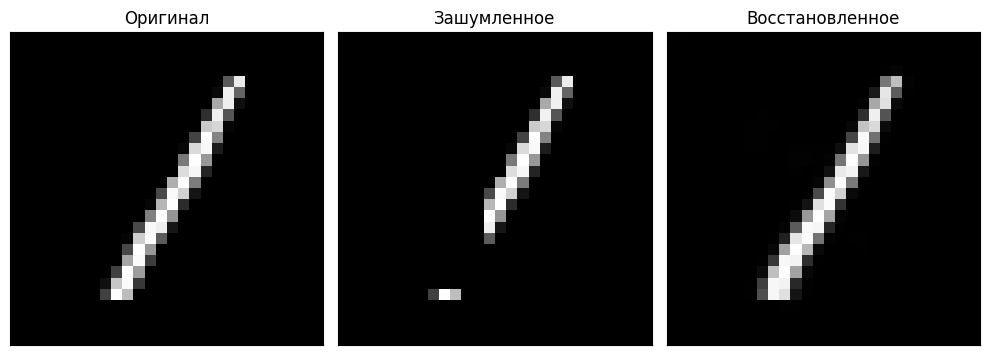

________________________
*** ЭПОХА: 40, Обучающая MSE: 0.00275, Тестовая MSE: 0.00431 ***
________________________


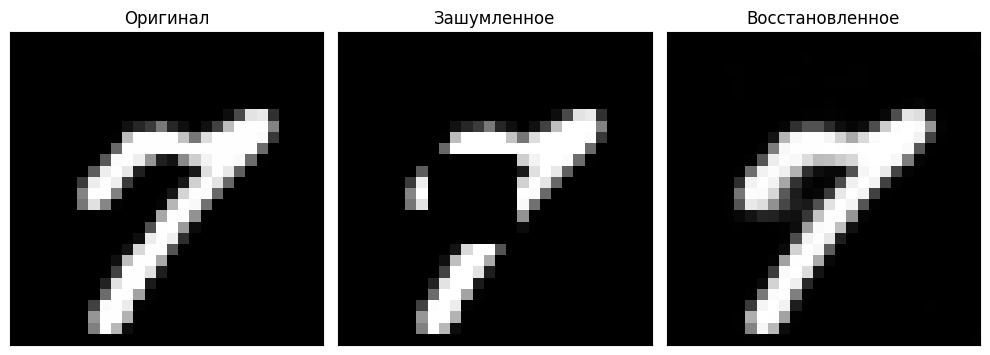

________________________
*** ЭПОХА: 41, Обучающая MSE: 0.00271, Тестовая MSE: 0.00443 ***
________________________


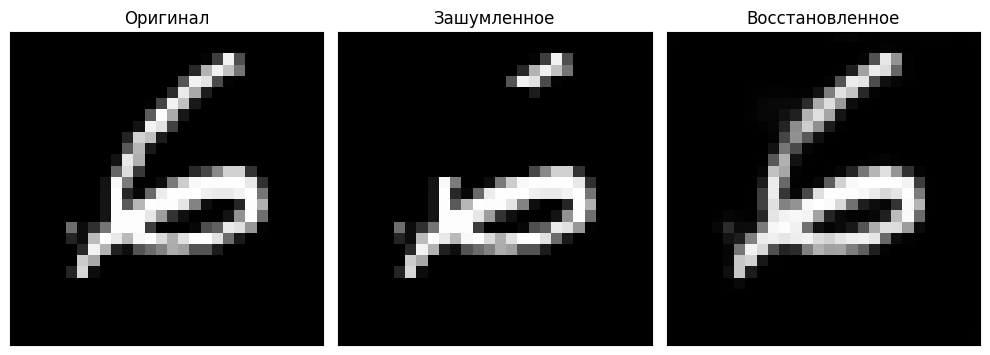

________________________
*** ЭПОХА: 42, Обучающая MSE: 0.00269, Тестовая MSE: 0.00466 ***
________________________


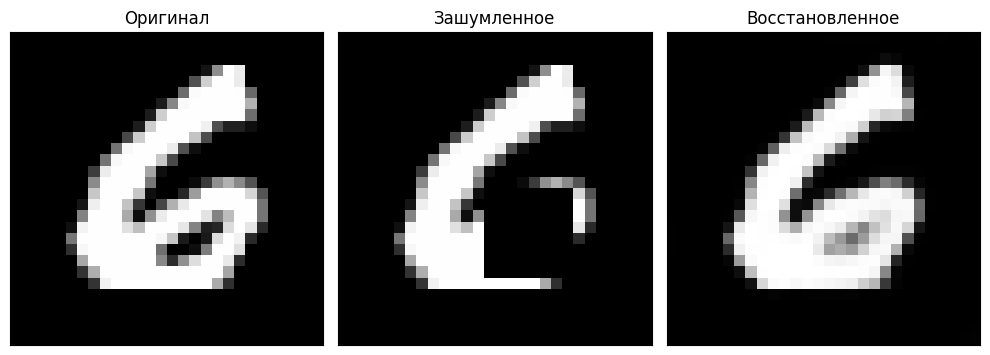

________________________
*** ЭПОХА: 43, Обучающая MSE: 0.00269, Тестовая MSE: 0.00456 ***
________________________


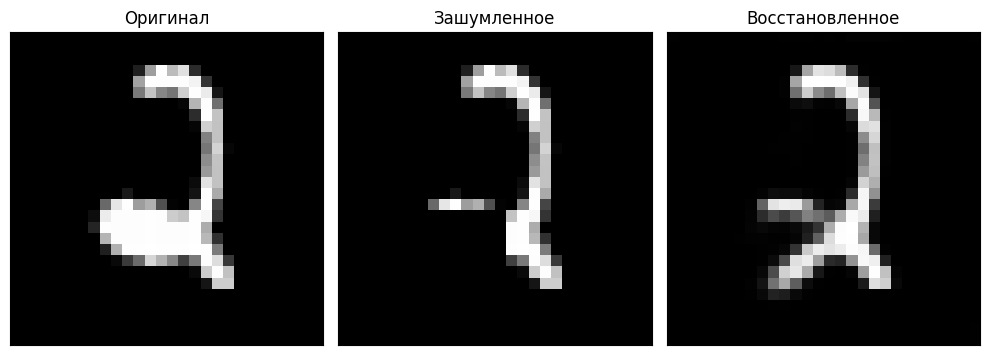

________________________
*** ЭПОХА: 44, Обучающая MSE: 0.00265, Тестовая MSE: 0.00425 ***
________________________


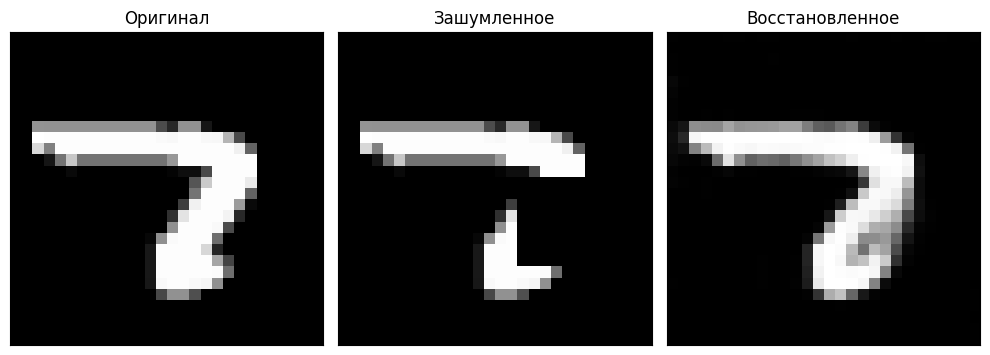

________________________
*** ЭПОХА: 45, Обучающая MSE: 0.00264, Тестовая MSE: 0.00432 ***
________________________


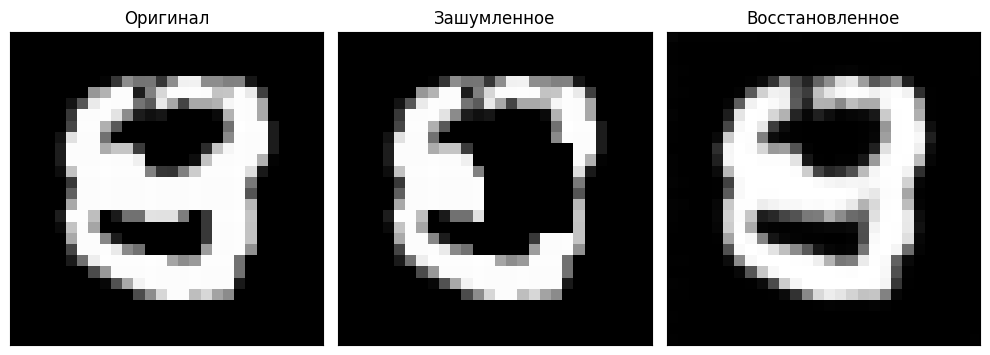

________________________
*** ЭПОХА: 46, Обучающая MSE: 0.00261, Тестовая MSE: 0.00441 ***
________________________


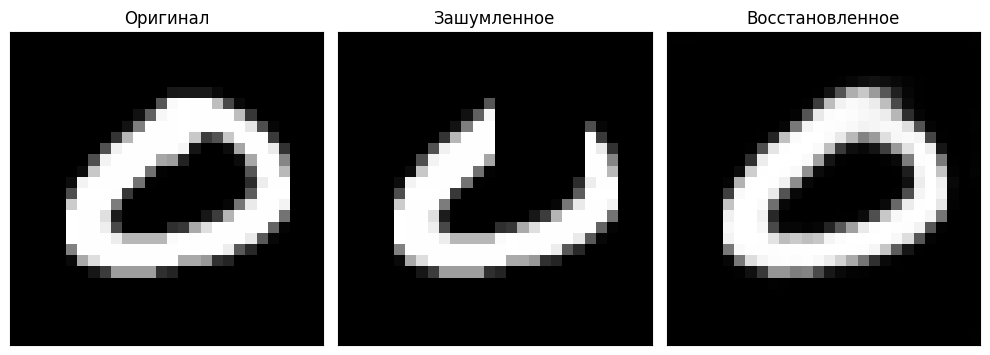

________________________
*** ЭПОХА: 47, Обучающая MSE: 0.00259, Тестовая MSE: 0.00439 ***
________________________


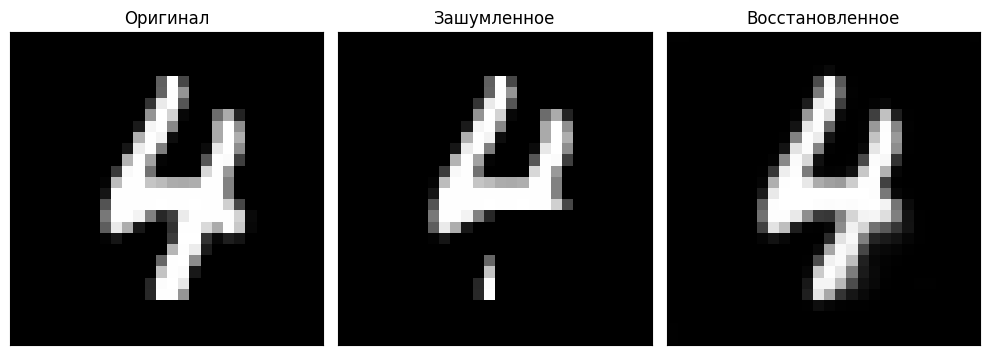

________________________
*** ЭПОХА: 48, Обучающая MSE: 0.00259, Тестовая MSE: 0.00433 ***
________________________


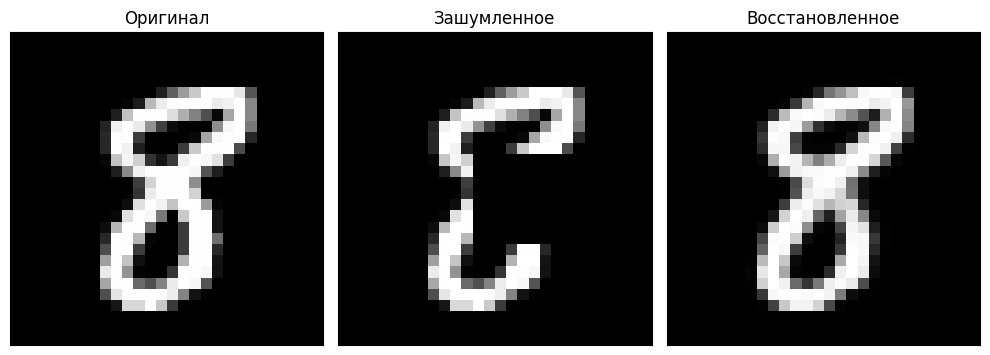

________________________
*** ЭПОХА: 49, Обучающая MSE: 0.00253, Тестовая MSE: 0.00463 ***
________________________


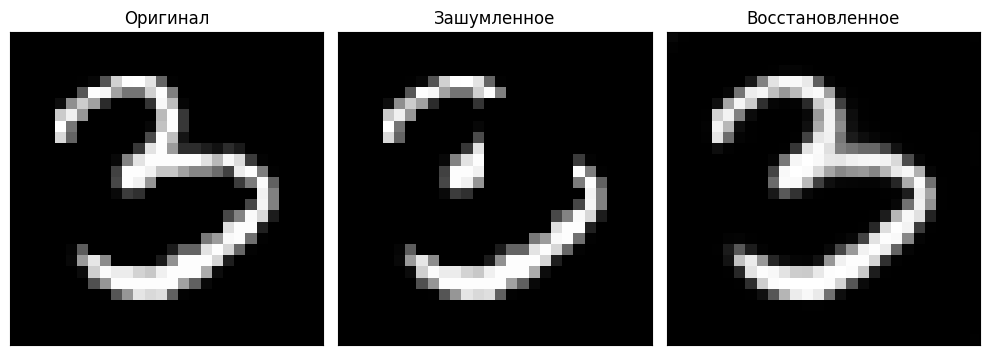

________________________
*** ЭПОХА: 50, Обучающая MSE: 0.00254, Тестовая MSE: 0.00426 ***
________________________


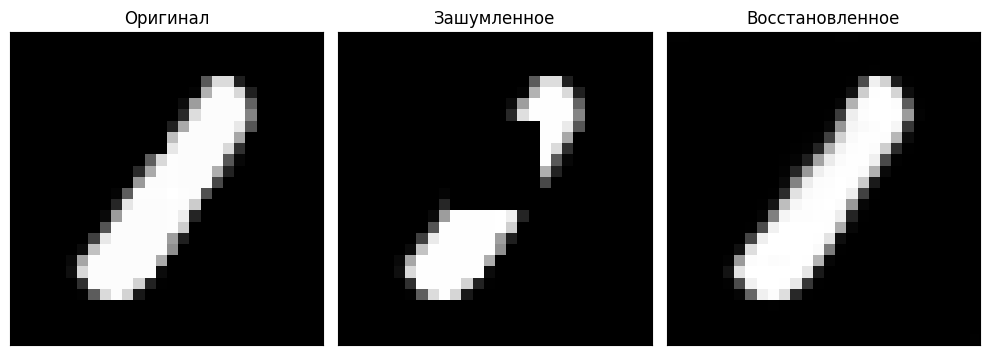

________________________
*** ЭПОХА: 51, Обучающая MSE: 0.00249, Тестовая MSE: 0.00459 ***
________________________


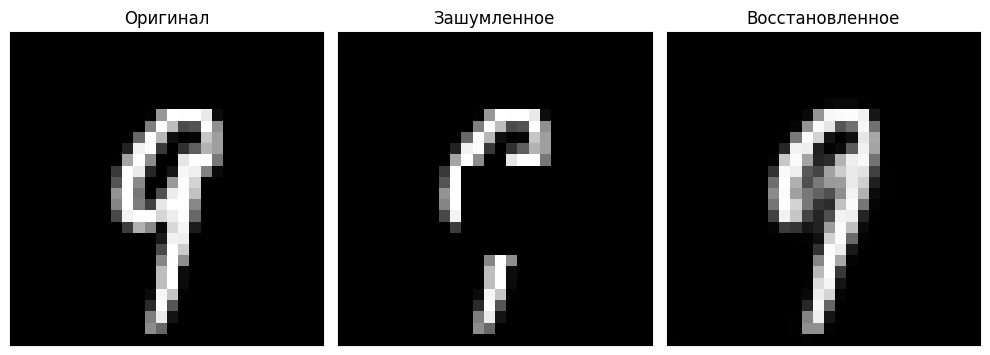

________________________
*** ЭПОХА: 52, Обучающая MSE: 0.00249, Тестовая MSE: 0.00434 ***
________________________


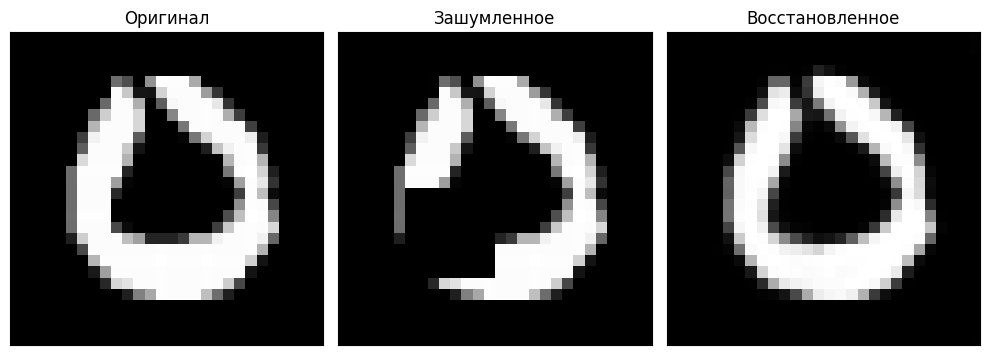

________________________
*** ЭПОХА: 53, Обучающая MSE: 0.00248, Тестовая MSE: 0.00430 ***
________________________


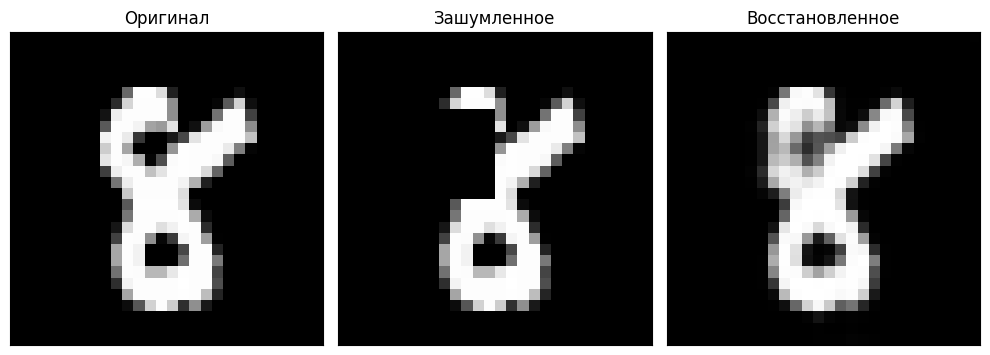

________________________
*** ЭПОХА: 54, Обучающая MSE: 0.00245, Тестовая MSE: 0.00429 ***
________________________


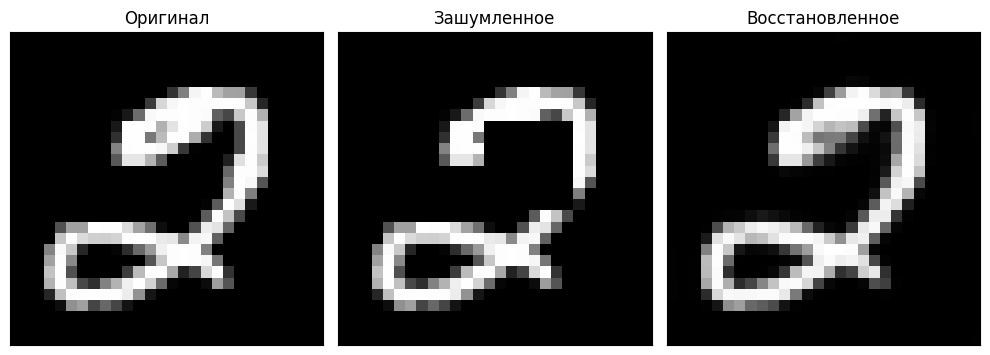

________________________
*** ЭПОХА: 55, Обучающая MSE: 0.00244, Тестовая MSE: 0.00440 ***
________________________


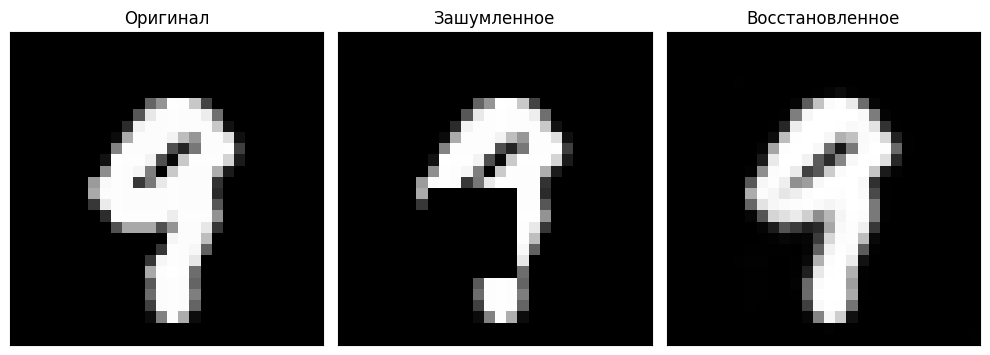

________________________
*** ЭПОХА: 56, Обучающая MSE: 0.00242, Тестовая MSE: 0.00429 ***
________________________


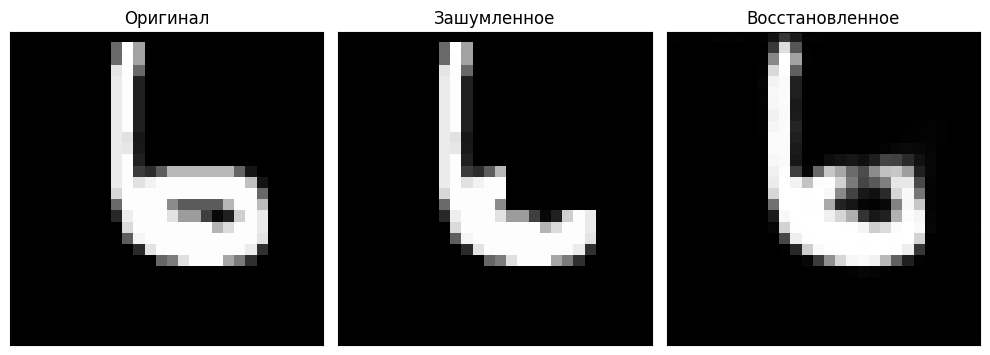

________________________
*** ЭПОХА: 57, Обучающая MSE: 0.00241, Тестовая MSE: 0.00429 ***
________________________


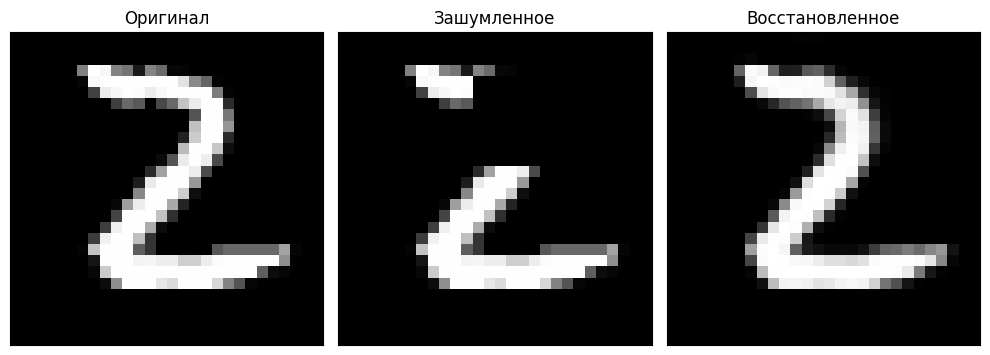

________________________
*** ЭПОХА: 58, Обучающая MSE: 0.00241, Тестовая MSE: 0.00446 ***
________________________


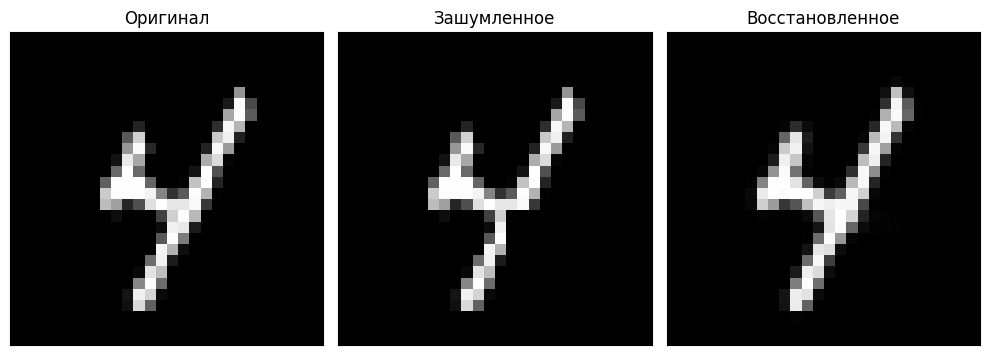

________________________
*** ЭПОХА: 59, Обучающая MSE: 0.00237, Тестовая MSE: 0.00431 ***
________________________


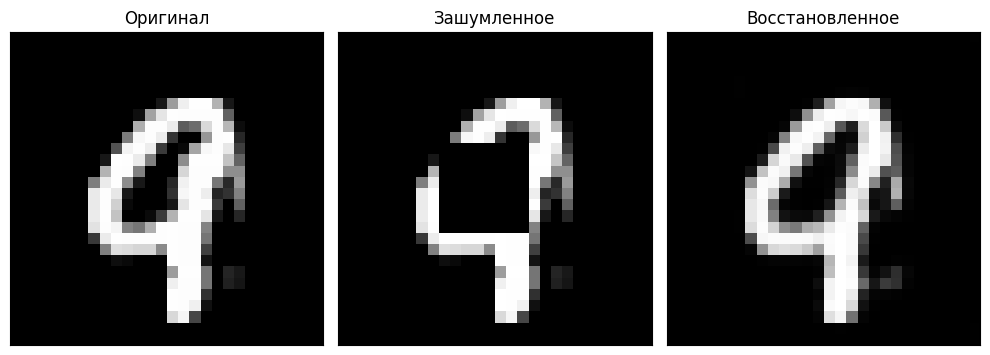

________________________
*** ЭПОХА: 60, Обучающая MSE: 0.00238, Тестовая MSE: 0.00516 ***
________________________


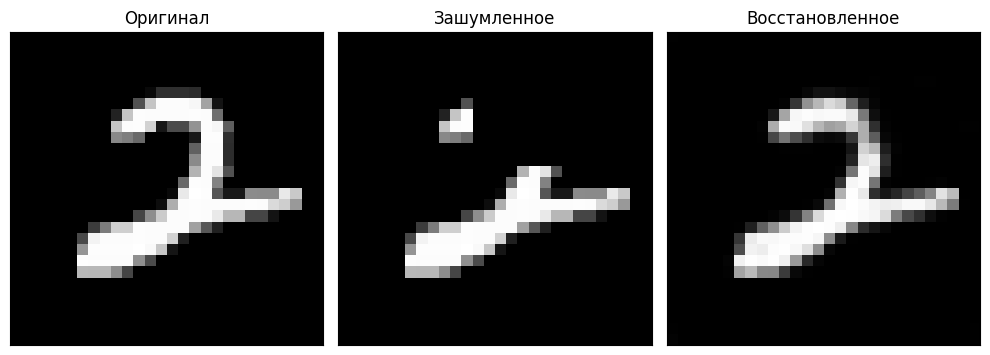

________________________
*** ЭПОХА: 61, Обучающая MSE: 0.00237, Тестовая MSE: 0.00446 ***
________________________


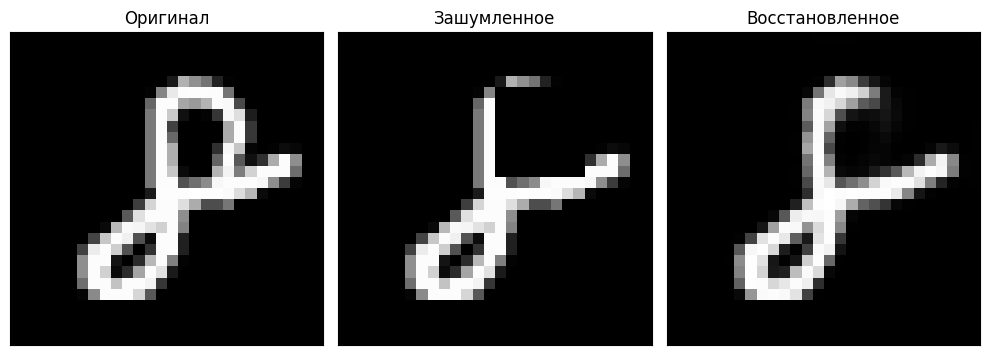

________________________
*** ЭПОХА: 62, Обучающая MSE: 0.00234, Тестовая MSE: 0.00430 ***
________________________


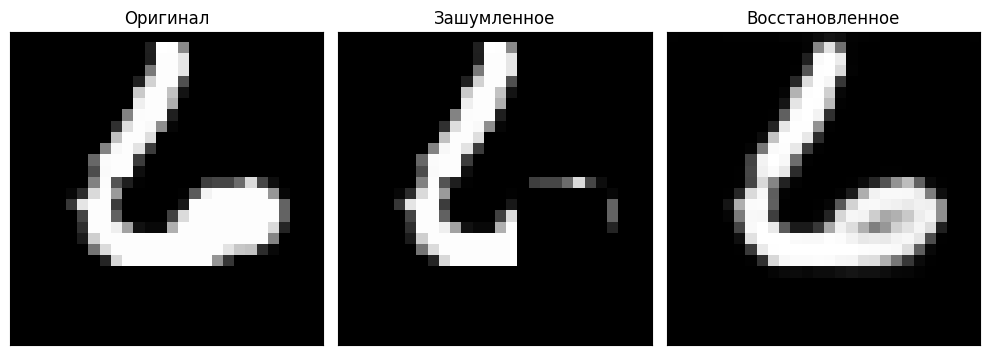

________________________
*** ЭПОХА: 63, Обучающая MSE: 0.00234, Тестовая MSE: 0.00438 ***
________________________


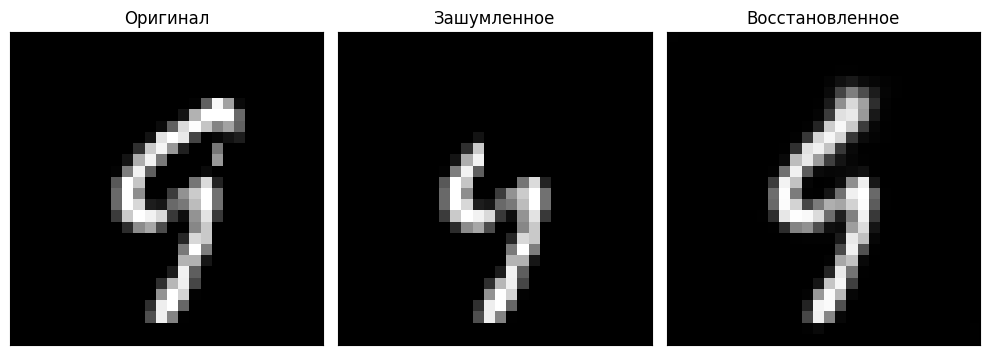

________________________
*** ЭПОХА: 64, Обучающая MSE: 0.00232, Тестовая MSE: 0.00457 ***
________________________


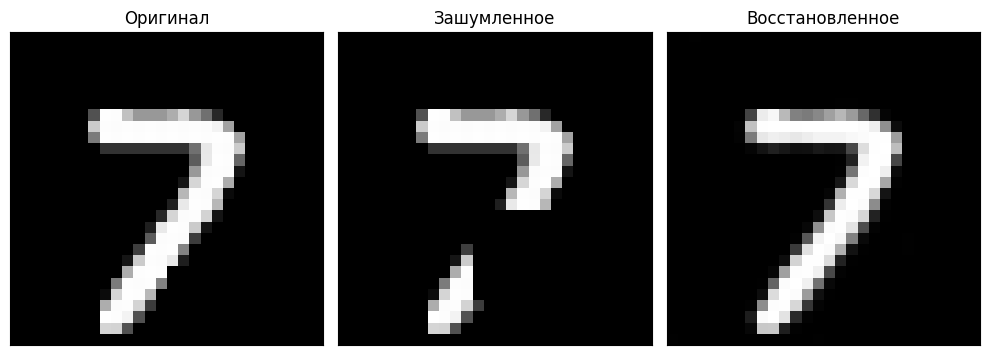

________________________
*** ЭПОХА: 65, Обучающая MSE: 0.00228, Тестовая MSE: 0.00440 ***
________________________


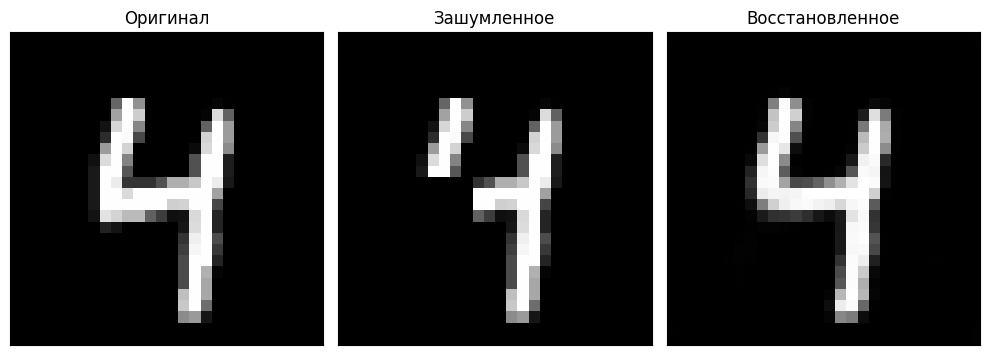

________________________
*** ЭПОХА: 66, Обучающая MSE: 0.00231, Тестовая MSE: 0.00440 ***
________________________


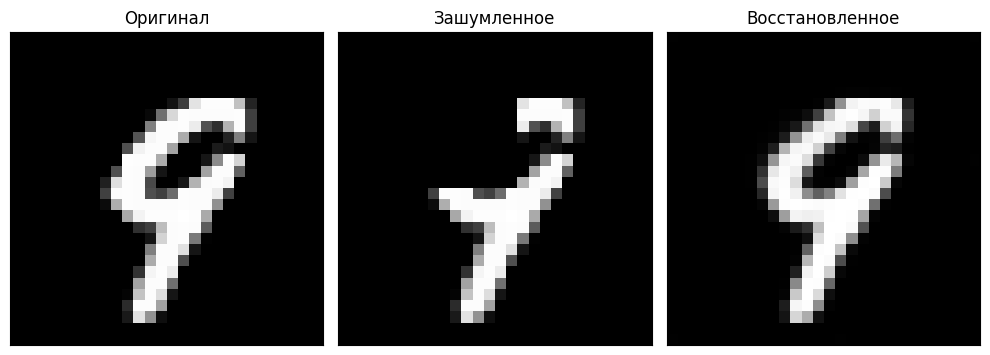

________________________
*** ЭПОХА: 67, Обучающая MSE: 0.00228, Тестовая MSE: 0.00432 ***
________________________


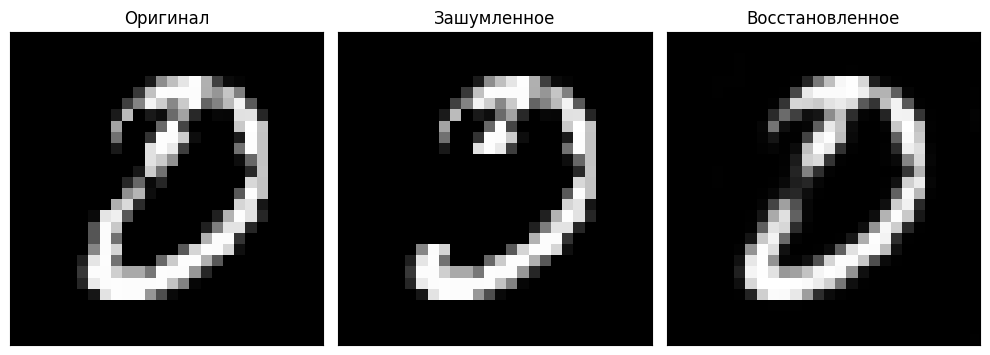

________________________
*** ЭПОХА: 68, Обучающая MSE: 0.00227, Тестовая MSE: 0.00435 ***
________________________


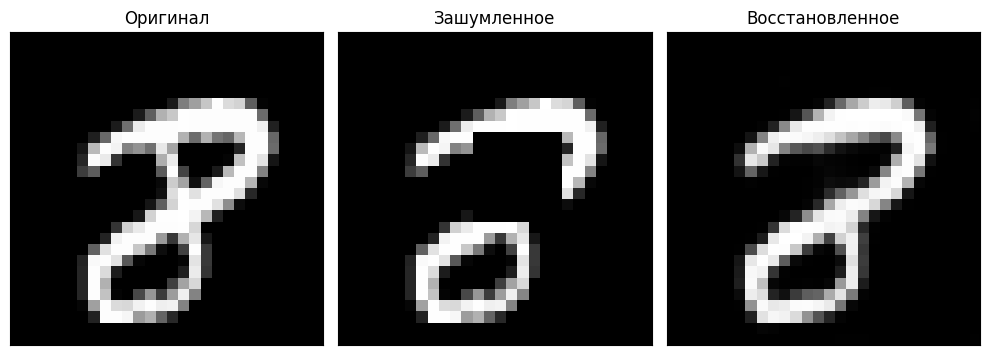

________________________
*** ЭПОХА: 69, Обучающая MSE: 0.00224, Тестовая MSE: 0.00481 ***
________________________


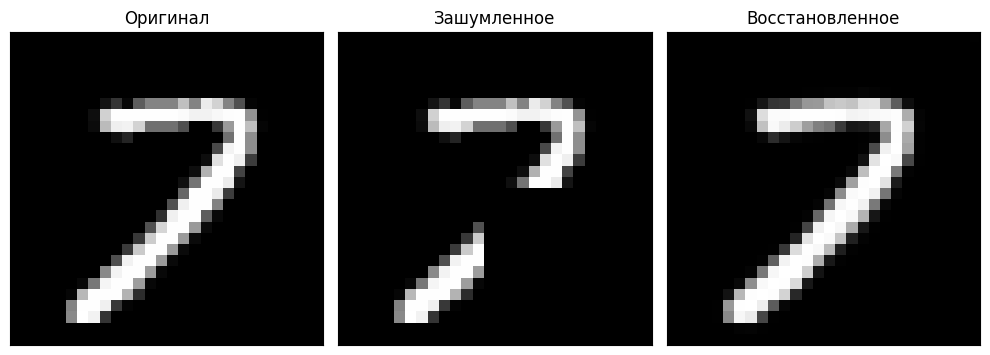

________________________
*** ЭПОХА: 70, Обучающая MSE: 0.00225, Тестовая MSE: 0.00447 ***
________________________


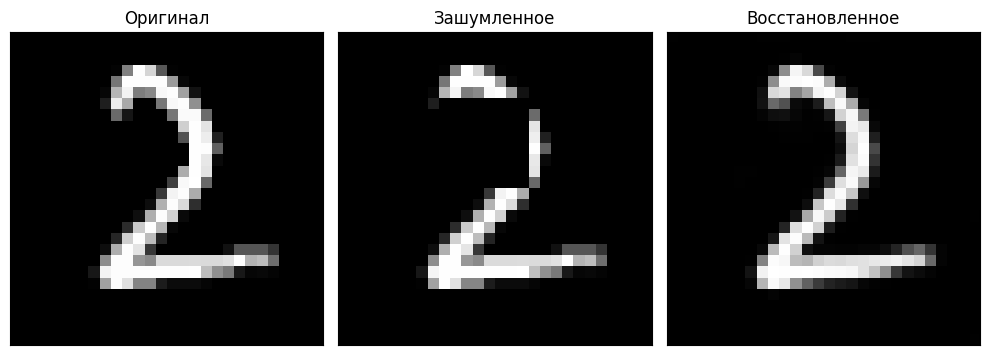

________________________
*** ЭПОХА: 71, Обучающая MSE: 0.00222, Тестовая MSE: 0.00436 ***
________________________


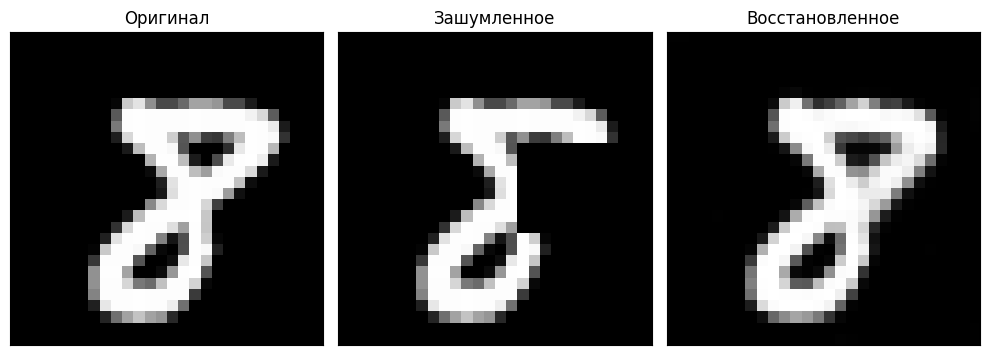

________________________
*** ЭПОХА: 72, Обучающая MSE: 0.00223, Тестовая MSE: 0.00443 ***
________________________


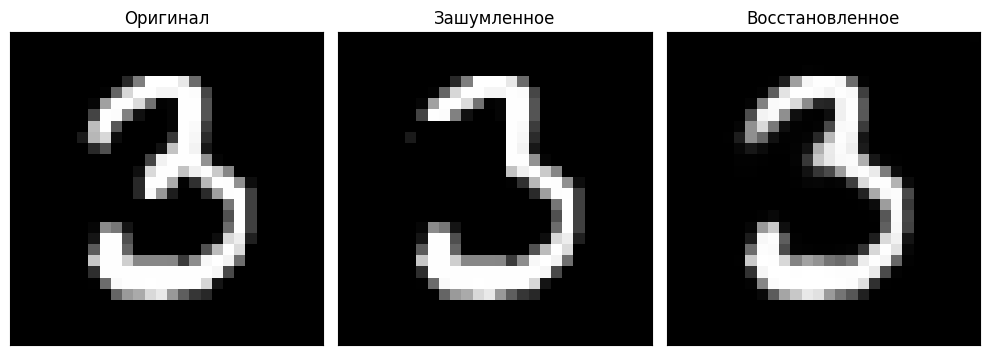

________________________
*** ЭПОХА: 73, Обучающая MSE: 0.00225, Тестовая MSE: 0.00442 ***
________________________


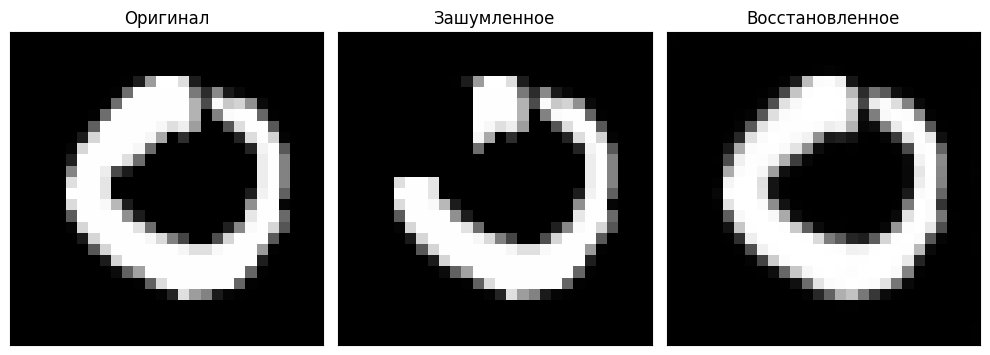

________________________
*** ЭПОХА: 74, Обучающая MSE: 0.00222, Тестовая MSE: 0.00433 ***
________________________


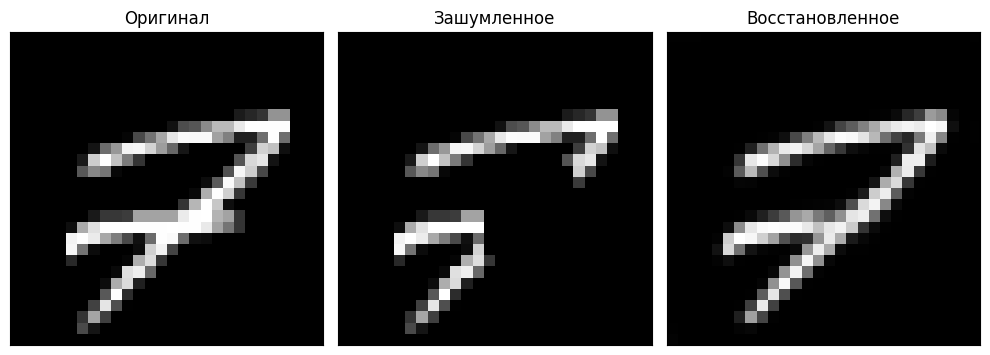

________________________
*** ЭПОХА: 75, Обучающая MSE: 0.00219, Тестовая MSE: 0.00444 ***
________________________


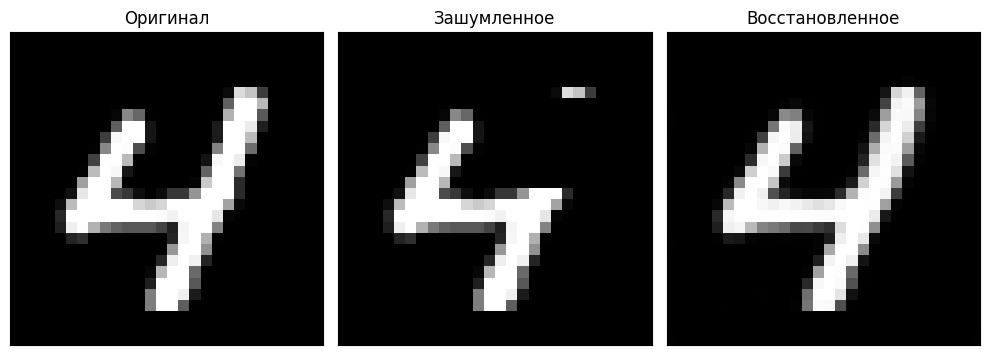

________________________
*** ЭПОХА: 76, Обучающая MSE: 0.00218, Тестовая MSE: 0.00444 ***
________________________


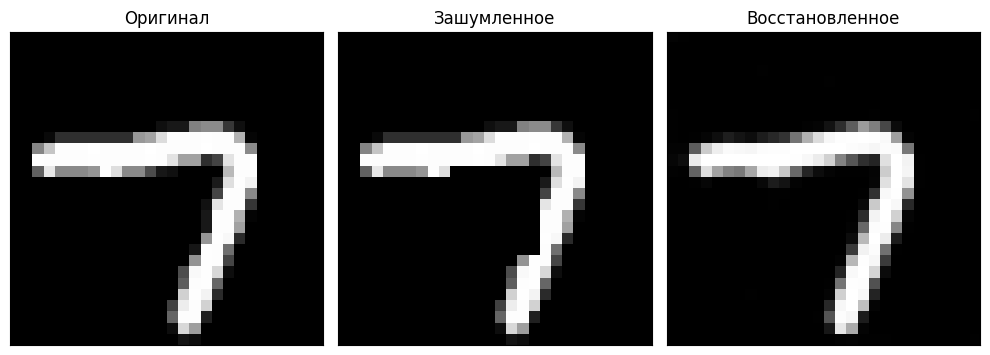

________________________
*** ЭПОХА: 77, Обучающая MSE: 0.00216, Тестовая MSE: 0.00430 ***
________________________


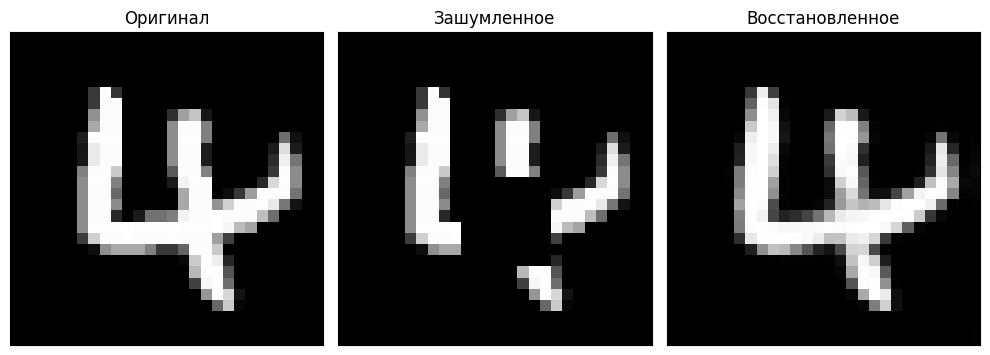

________________________
*** ЭПОХА: 78, Обучающая MSE: 0.00216, Тестовая MSE: 0.00433 ***
________________________


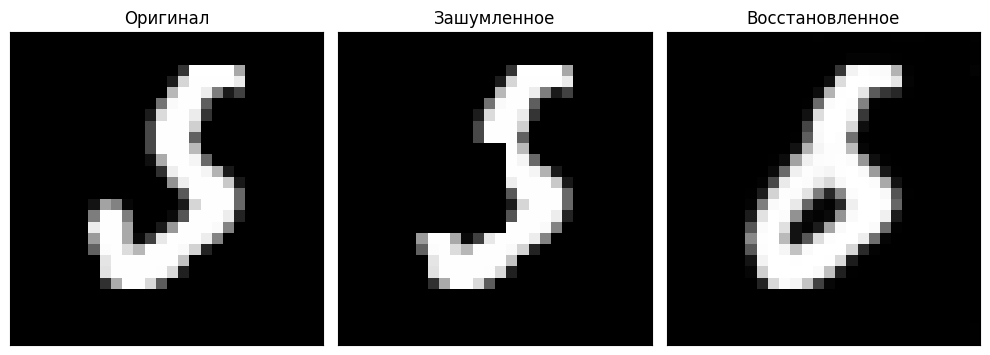

________________________
*** ЭПОХА: 79, Обучающая MSE: 0.00216, Тестовая MSE: 0.00445 ***
________________________


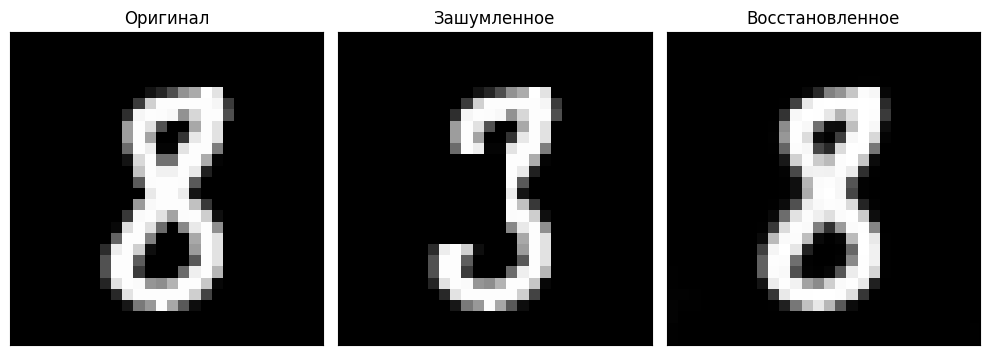

________________________
*** ЭПОХА: 80, Обучающая MSE: 0.00214, Тестовая MSE: 0.00455 ***
________________________


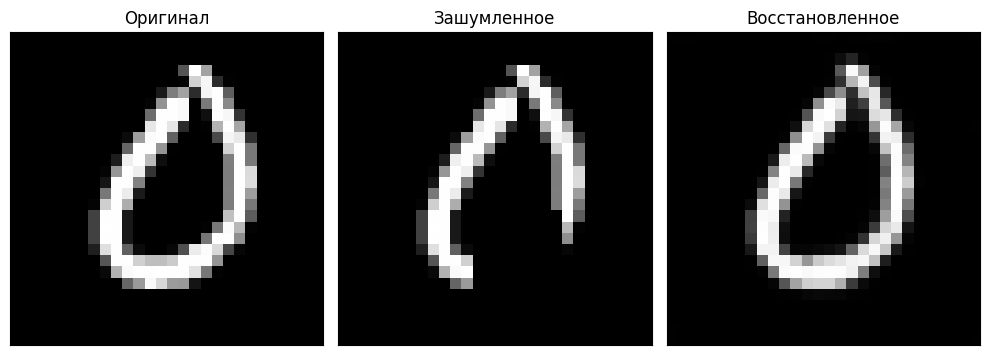

________________________
*** ЭПОХА: 81, Обучающая MSE: 0.00214, Тестовая MSE: 0.00431 ***
________________________


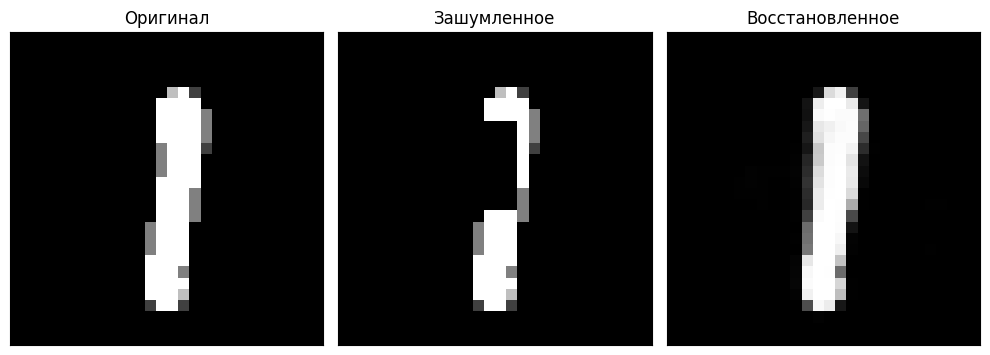

________________________
*** ЭПОХА: 82, Обучающая MSE: 0.00211, Тестовая MSE: 0.00436 ***
________________________


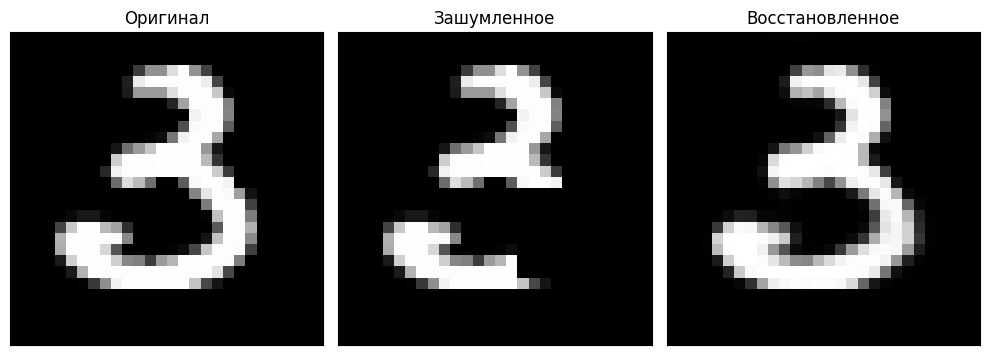

________________________
*** ЭПОХА: 83, Обучающая MSE: 0.00210, Тестовая MSE: 0.00483 ***
________________________


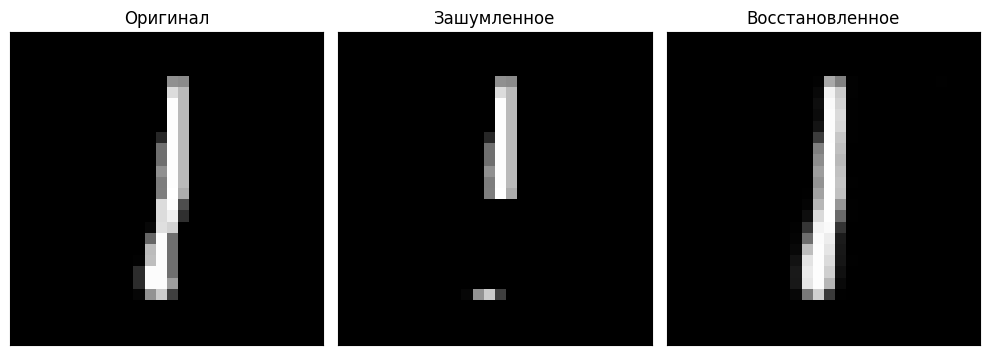

________________________
*** ЭПОХА: 84, Обучающая MSE: 0.00210, Тестовая MSE: 0.00445 ***
________________________


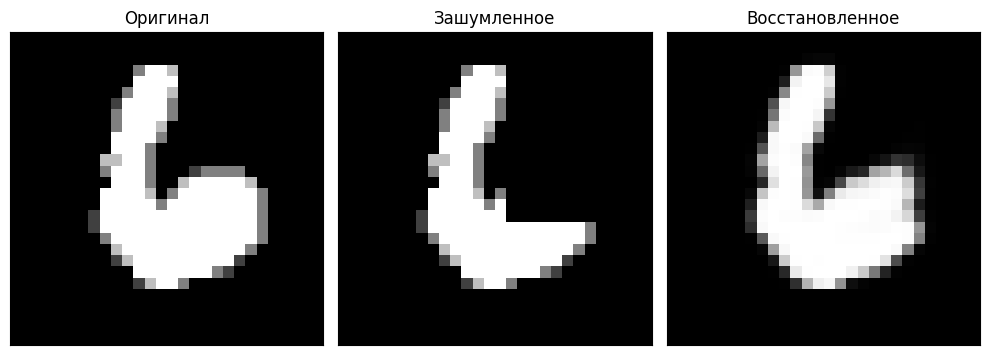

________________________
*** ЭПОХА: 85, Обучающая MSE: 0.00208, Тестовая MSE: 0.00443 ***
________________________


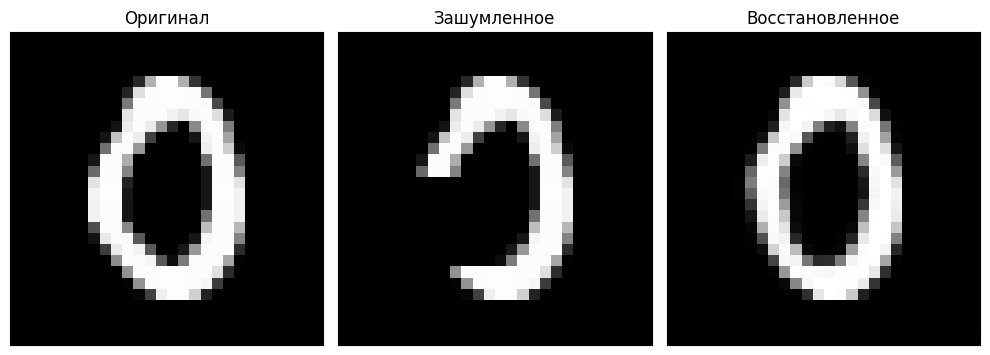

________________________
*** ЭПОХА: 86, Обучающая MSE: 0.00210, Тестовая MSE: 0.00444 ***
________________________


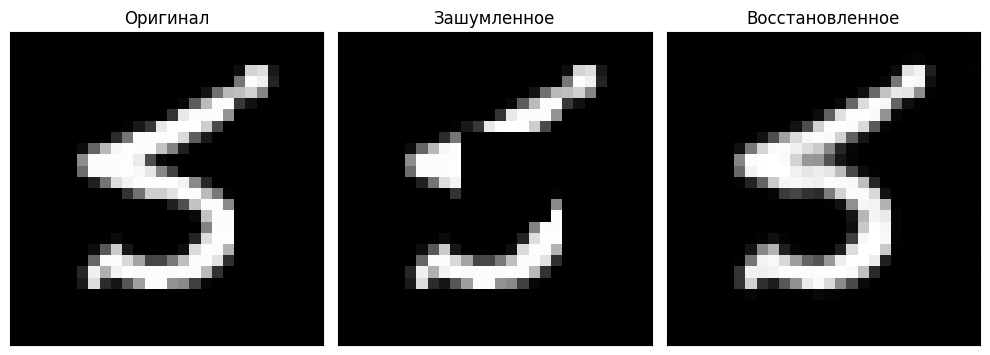

________________________
*** ЭПОХА: 87, Обучающая MSE: 0.00209, Тестовая MSE: 0.00433 ***
________________________


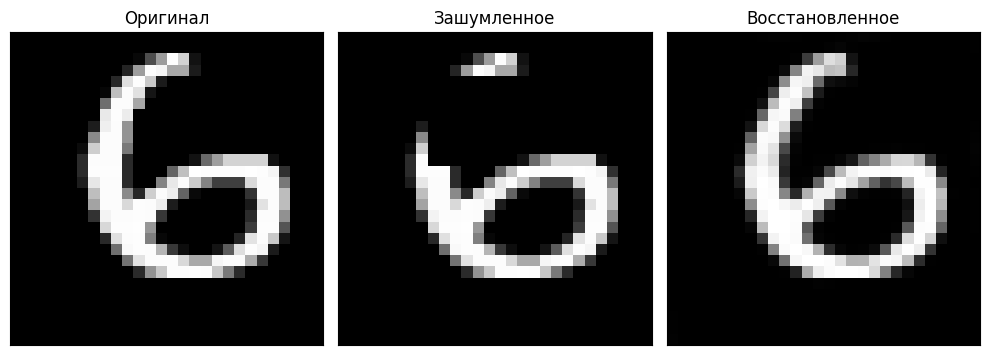

________________________
*** ЭПОХА: 88, Обучающая MSE: 0.00207, Тестовая MSE: 0.00476 ***
________________________


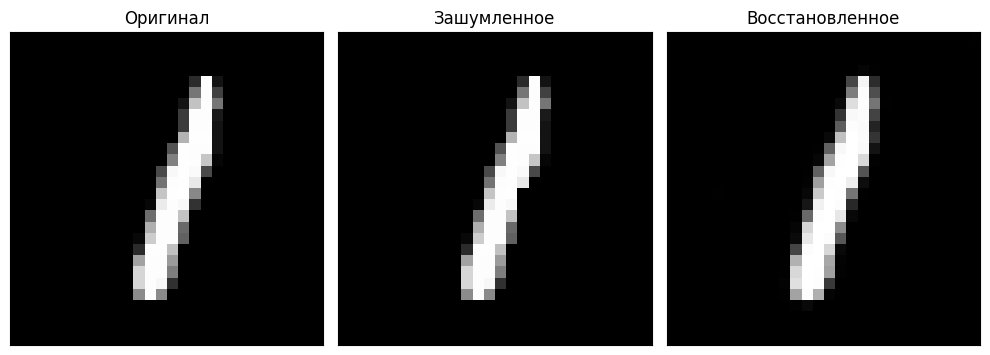

________________________
*** ЭПОХА: 89, Обучающая MSE: 0.00209, Тестовая MSE: 0.00447 ***
________________________


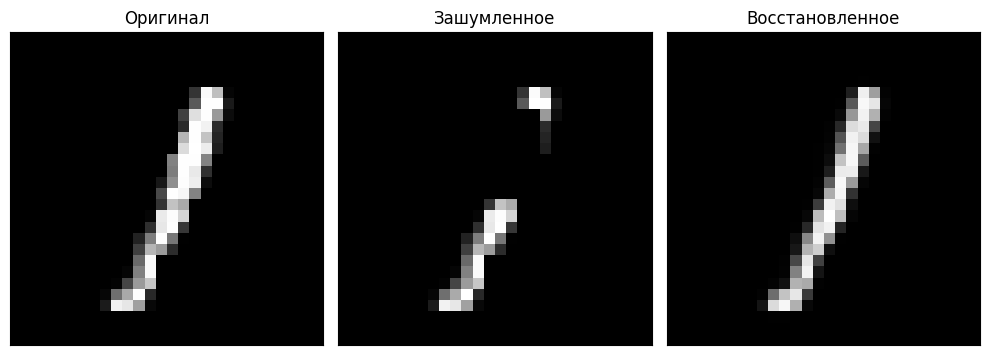

________________________
*** ЭПОХА: 90, Обучающая MSE: 0.00206, Тестовая MSE: 0.00520 ***
________________________


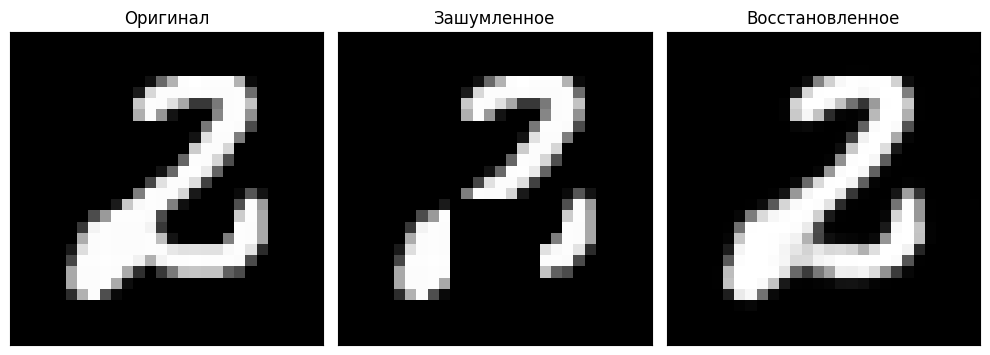

________________________
*** ЭПОХА: 91, Обучающая MSE: 0.00207, Тестовая MSE: 0.00451 ***
________________________


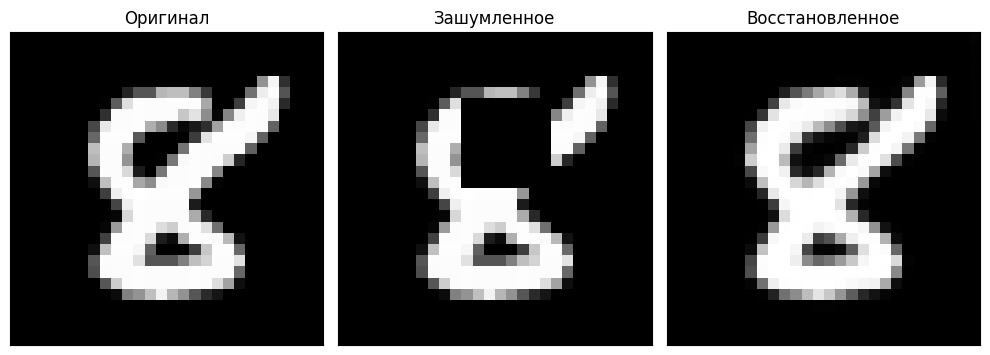

________________________
*** ЭПОХА: 92, Обучающая MSE: 0.00206, Тестовая MSE: 0.00459 ***
________________________


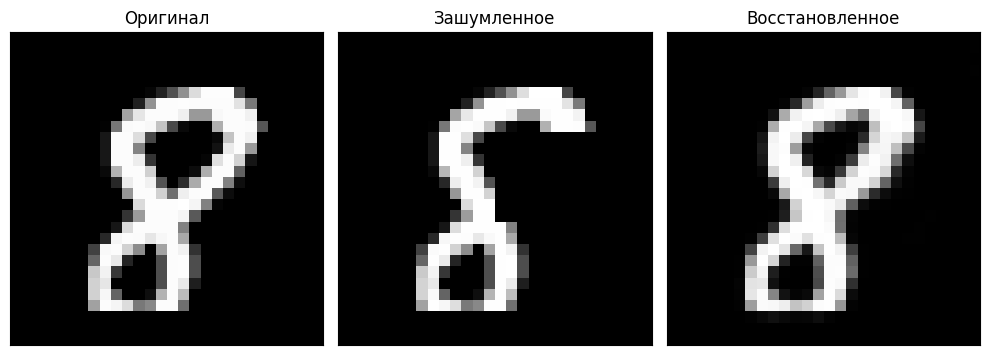

________________________
*** ЭПОХА: 93, Обучающая MSE: 0.00203, Тестовая MSE: 0.00440 ***
________________________


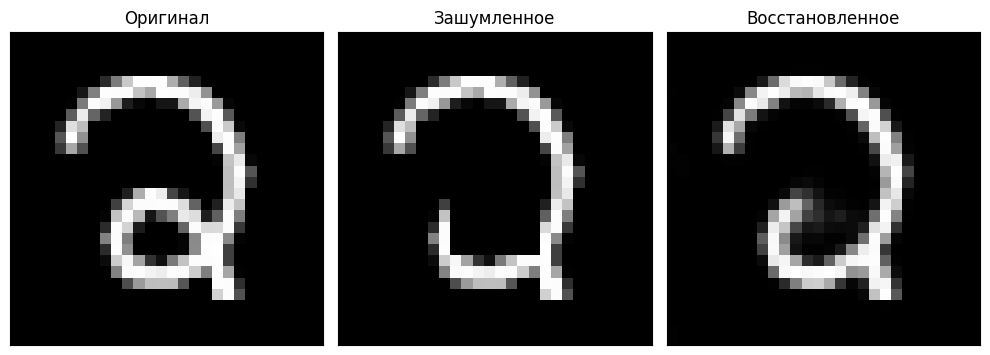

________________________
*** ЭПОХА: 94, Обучающая MSE: 0.00204, Тестовая MSE: 0.00436 ***
________________________


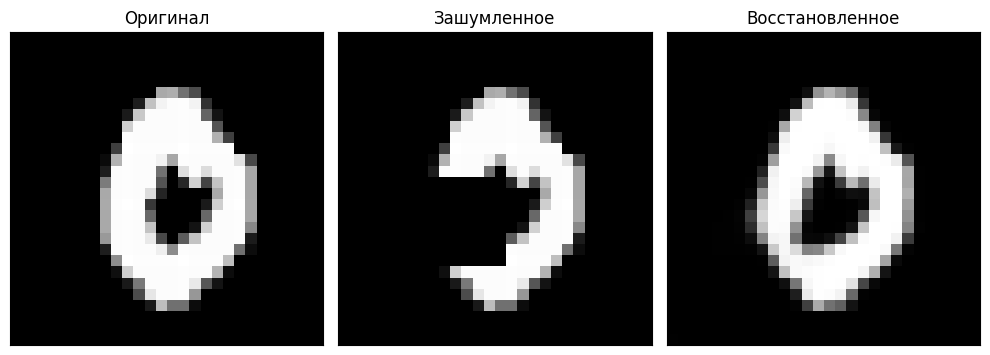

________________________
*** ЭПОХА: 95, Обучающая MSE: 0.00202, Тестовая MSE: 0.00439 ***
________________________


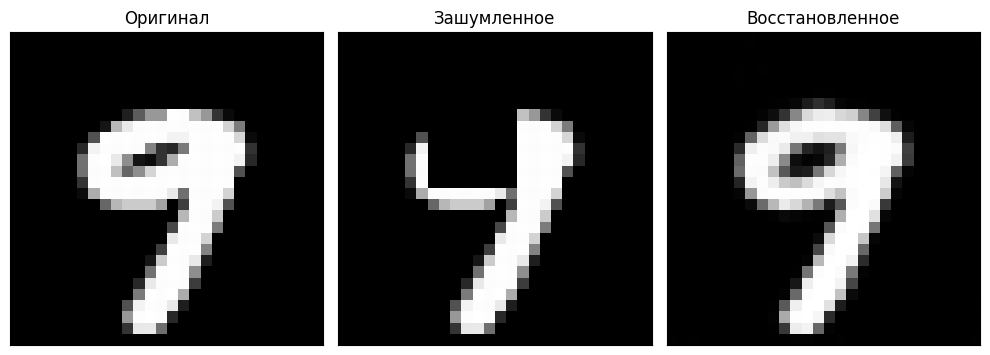

________________________
*** ЭПОХА: 96, Обучающая MSE: 0.00201, Тестовая MSE: 0.00451 ***
________________________


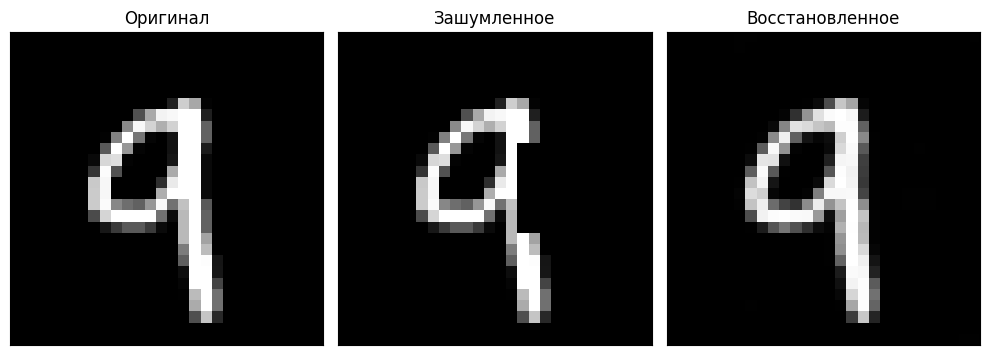

________________________
*** ЭПОХА: 97, Обучающая MSE: 0.00202, Тестовая MSE: 0.00449 ***
________________________


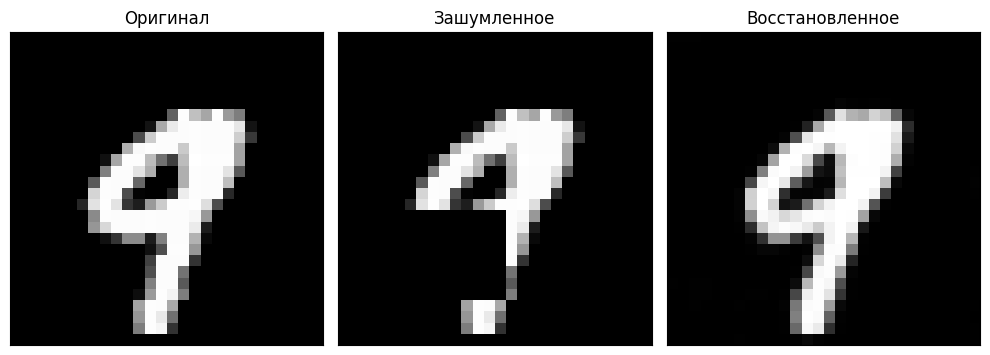

________________________
*** ЭПОХА: 98, Обучающая MSE: 0.00202, Тестовая MSE: 0.00455 ***
________________________


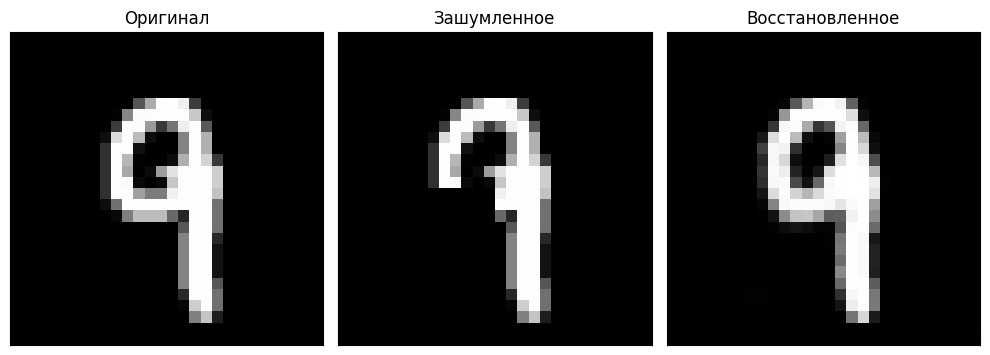

________________________
*** ЭПОХА: 99, Обучающая MSE: 0.00200, Тестовая MSE: 0.00443 ***
________________________


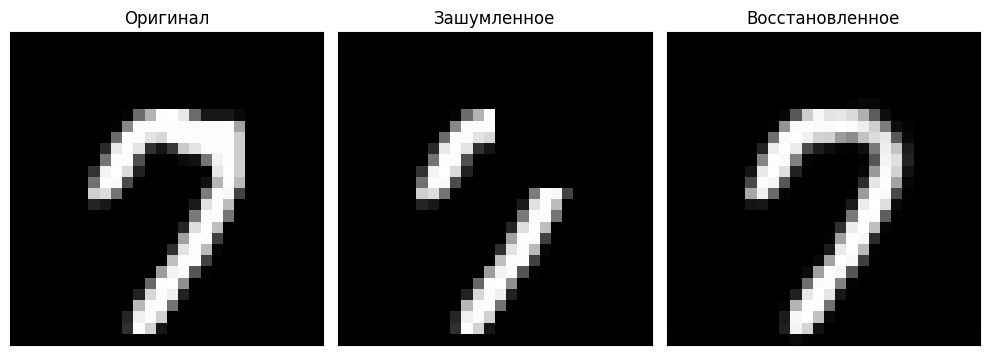

________________________
*** ЭПОХА: 100, Обучающая MSE: 0.00199, Тестовая MSE: 0.00447 ***
________________________


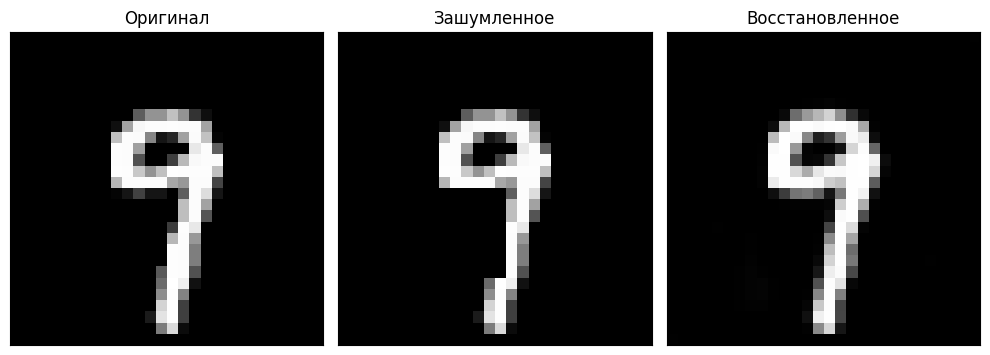

In [ ]:
history = denoising_ae.fit(
    X_train_noisy,
    X_train,
    epochs=100,
    batch_size=256,
    shuffle=True,
    validation_data=(X_test_noisy, X_test),
    callbacks=[LambdaCallback(on_epoch_end=denoising_callback)],
    verbose=0,
)


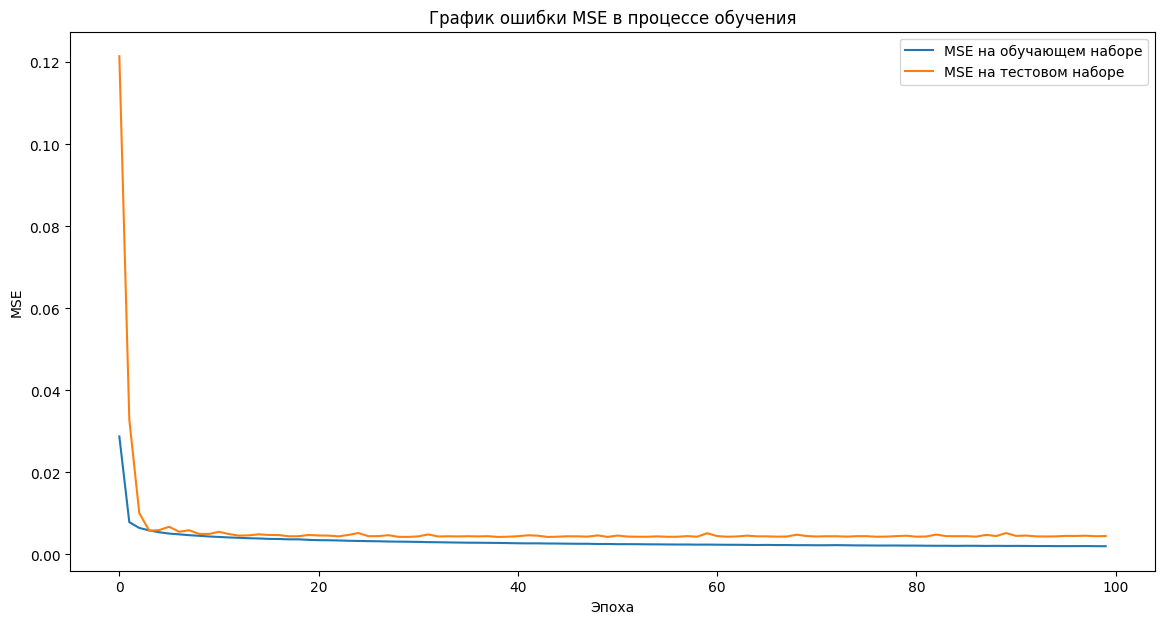

In [21]:
plt.figure(figsize=(14, 7))
plt.plot(history.history["loss"], label="MSE на обучающем наборе")
plt.plot(history.history["val_loss"], label="MSE на тестовом наборе")
plt.ylabel("MSE")
plt.xlabel("Эпоха")
plt.legend()
plt.title("График ошибки MSE в процессе обучения")
plt.show()


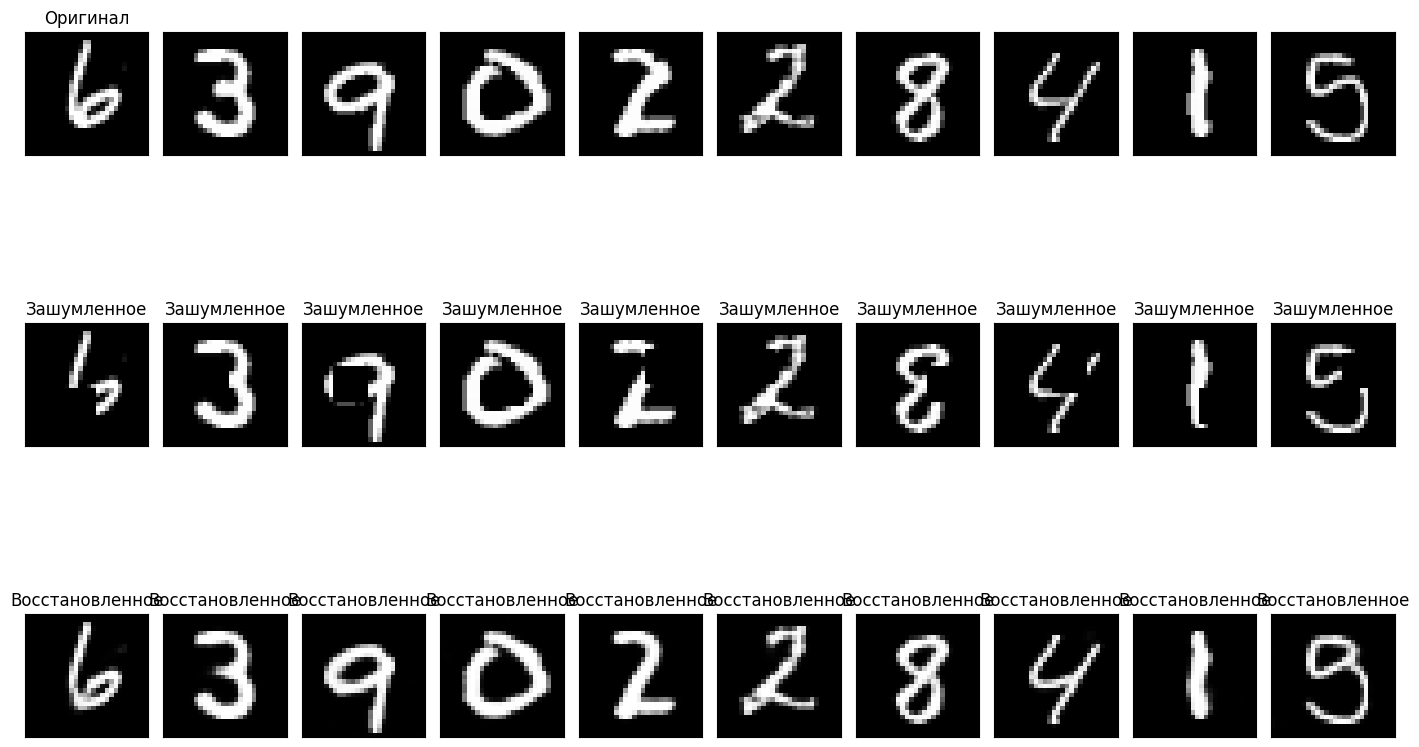

In [ ]:
reconstructed_test_images = denoising_ae.predict(X_test_noisy, verbose=0)

plt.figure(figsize=(14, 10))

for i in range(1, 10 + 1):
    index = np.random.randint(0, X_test.shape[0])


    ax = plt.subplot(3, 10, i)
    plt.imshow(X_test[index].squeeze(), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 1:
        ax.set_title("Оригинал")


    ax = plt.subplot(3, 10, i + 10)
    plt.imshow(X_test_noisy[index].squeeze(), cmap="gray")
    ax.set_title("Зашумленное")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    ax = plt.subplot(3, 10, i + 2 * 10)
    plt.imshow(reconstructed_test_images[index].squeeze(), cmap="gray")
    ax.set_title("Восстановленное")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()


In [23]:
final_test_loss = history.history["val_loss"][-1]
print(f"\nФинальная ошибка MSE на тестовой выборке: {final_test_loss:.5f}")


Финальная ошибка MSE на тестовой выборке: 0.00447
